In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fudanspennsmall/model_epoch_116(5).pth
/kaggle/input/fudanspennsmall/detection/train.py
/kaggle/input/fudanspennsmall/src/pinjie.jpeg
/kaggle/input/fudanspennsmall/SPenn/SPenn/PedMasks/MYO_0031.jpg
/kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_2154.jpg
/kaggle/input/fudanspennsmall/SPenn/SPenn/backmasks/LYT_2154.jpg
/kaggle/input/fudanspennsmall/SPenn/SPenn/test/LYT_3050.jpg
/kaggle/input/fudanspennsmall/SPenn/SPenn/PNGImages/MYO_0031.jpg


In [2]:
import os
import sys
sys.path.append('/kaggle/input/fudanspennsmall/')

import numpy as np
import torch
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor,MaskRCNN_ResNet50_FPN_Weights
from detection.engine import train_one_epoch, evaluate
import detection.utils as utils
import detection.transforms as T
# import mymaskrcnn,dropblock,maskrcnnmodel
from mymaskrcnn import custom_maskrcnn_resnet50_fpn
from uncertaintyAna import visualize_top_uncertain_images, visualize_top_uncertain_images_gpu

In [3]:
# http://pytorch.org/tutorials/intermediate/torchvision_tutorial.html



class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms

        # 定义类别映射
        self.CLASSES = {
            'EOS': 1,
            'LYT': 2,
            'MON': 3,
            'MYO': 4,
            'NGB': 5,
            'NGS': 6,
            'EBO': 7,
            'BAS': 8
        }  # 背景为0，目标类别从1开始

        # 匹配图像和掩码文件
        self.imgs = list(sorted([f for f in os.listdir(os.path.join(root, "PNGImages")) if f.endswith(('.png', '.jpg'))]))
        self.masks = list(sorted([f for f in os.listdir(os.path.join(root, "PedMasks")) if f.endswith(('.png', '.jpg'))]))

        if len(self.imgs) != len(self.masks):
            raise ValueError(f"Number of images ({len(self.imgs)}) and masks ({len(self.masks)}) do not match!")

        for img, mask in zip(self.imgs, self.masks):
            if os.path.splitext(img)[0] != os.path.splitext(mask)[0]:
                raise ValueError(f"Mismatch between image and mask: {img} and {mask}")

        # 创建保存目录
        self.output_dir = "/kaggle/working"
        self.images_dir = os.path.join(self.output_dir, "PNGImages")
        self.masks_dir = os.path.join(self.output_dir, "PedMasks")
        os.makedirs(self.images_dir, exist_ok=True)
        os.makedirs(self.masks_dir, exist_ok=True)

    def get_class_from_filename(self, filename):
        class_name = filename.split('_')[0]
        if class_name not in self.CLASSES:
            print(f"Warning: Class name '{class_name}' not found in CLASSES. Defaulting to background (0).")
        return self.CLASSES.get(class_name, 0)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        mask_name = self.masks[idx]

        img_path = os.path.join(self.root, "PNGImages", img_name)
        mask_path = os.path.join(self.root, "PedMasks", mask_name)

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        mask = np.array(mask)

        # 保存原始图像和掩码
        img.save(os.path.join(self.images_dir, img_name))
        Image.fromarray(mask).save(os.path.join(self.masks_dir, mask_name))

        # 获取类别标签
        class_id = self.get_class_from_filename(img_name)

        # 合并所有掩码为一个整体
        combined_mask = (mask > 0).astype(np.uint8)
        pos = np.where(combined_mask)

        if pos[0].size == 0 or pos[1].size == 0:
            raise ValueError(f"Invalid mask at index {idx}")

        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])

        # 创建目标框和掩码
        boxes = torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32)
        masks = torch.as_tensor(combined_mask, dtype=torch.uint8).unsqueeze(0)
        labels = torch.tensor([class_id], dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": torch.tensor([idx]),
            "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            "iscrowd": torch.zeros((1,), dtype=torch.int64),
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


def get_model_instance_segmentation(num_classes):
    # model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    model = custom_maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

def get_transform(train):
    transforms = [T.ToTensor()]
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

def main():
    # 判断当前机器的GPU是否可用
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # 背景 + 目标类别
    num_classes = 9

    # dataset = PennFudanDataset('/kaggle/input/fudanspennsmall/SPenn/SPenn', get_transform(train=True))
    # dataset_test = PennFudanDataset('/kaggle/input/fudanspennsmall/SPenn/SPenn', get_transform(train=False))

    dataset = PennFudanDataset('/kaggle/input/fudanspennsmall/SPenn/SPenn', get_transform(train=True))
    dataset_test = PennFudanDataset('/kaggle/input/fudanspennsmall/SPenn/SPenn', get_transform(train=False))

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=utils.collate_fn
    )
    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=4, shuffle=False, num_workers=4, collate_fn=utils.collate_fn
    )

    model = get_model_instance_segmentation(num_classes)
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    # optimizer = torch.optim.Adam(params, lr=0.005, weight_decay=0.0005)
    # # 使用 Adam 优化器
    # params = [p for p in model.parameters() if p.requires_grad]
    # optimizer = torch.optim.Adam(params, lr=0.005, weight_decay=0.0005)

    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    num_epochs = 20 #40
    from tqdm import tqdm

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        # tqdm 监视 data_loader 的进度
        data_loader_with_progress = tqdm(data_loader, desc=f"Training Epoch {epoch + 1}", unit="batch")
    
        # 使用 train_one_epoch 进行训练
        train_one_epoch(model, optimizer, data_loader_with_progress, device, epoch, print_freq=len(data_loader))
        
        # 更新学习率调度器
        lr_scheduler.step()
    
        # 评估模型
        evaluate(model, data_loader_test, device=device)
    
        # 保存模型权重
        output_dir = "/kaggle/working/"
        torch.save(model.state_dict(), os.path.join(output_dir, f"model_epoch_{epoch+1}.pth"))
    
    print("Training complete. Model weights are saved.")

import os
import json
import sys
from datetime import datetime
from contextlib import redirect_stdout, redirect_stderr

class MultiOutputLogger:
    def __init__(self, output_path):
        self.output_path = output_path
        self.logs = []
        self.console = sys.stdout  # 保存原始 stdout

    def write(self, message):
        """保存日志并打印到终端"""
        self.logs.append(message)
        self.console.write(message)  # 打印到终端

    def flush(self):
        """刷新输出流"""
        self.console.flush()

    def load_existing_logs(self):
        """加载现有日志文件"""
        if os.path.exists(self.output_path):
            with open(self.output_path, 'r') as f:
                return json.load(f)
        return []

    def save_to_file(self, run_id):
        """将新日志追加到文件"""
        existing_logs = self.load_existing_logs()
        run_logs = {
            "run_id": run_id,
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "logs": self.logs
        }
        existing_logs.append(run_logs)
        with open(self.output_path, 'w') as f:
            json.dump(existing_logs, f, indent=4)

# 使用输出重定向功能
def main_with_logging():
    log_path = "/kaggle/working/training_logs.json"  # 保存日志的路径
    logger = MultiOutputLogger(log_path)

    # 为每次运行创建唯一的运行标识符
    run_id = f"run_{len(logger.load_existing_logs()) + 1}"

    # 使用上下文管理器捕获输出，同时打印到终端
    with redirect_stdout(logger), redirect_stderr(logger):
        main()  # 调用您的主函数，所有输出将被捕获并记录

    # 保存日志到文件
    logger.save_to_file(run_id)
    print(f"Training logs saved to: {log_path}")



if __name__ == "__main__":
    # main()
    main_with_logging()



Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|##########| 170M/170M [00:00<00:00, 331MB/s] 
Epoch 1/20
Training Epoch 1:   0%|          | 0/19 [00:00<?, ?batch/s]/kaggle/input/fudanspennsmall/detection/engine.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):
Training Epoch 1: 100%|##########| 19/19 [00:11<00:00,  1.63batch/s]
Epoch: [0] lr: 0.005000  loss: 1.2014 (2.3757)  loss_classifier: 0.3508 (1.0040)  loss_box_reg: 0.1484 (0.1441)  loss_mask: 0.6826 (1.1994)  loss_objectness: 0.0159 (0.0209)  loss_rpn_box_reg: 0.0063 (0.0072)
creating index...
index created!
Averaged stats: model_time: 0.5598 (0.5233)  evaluator_time: 0.0087 (0.0085)
Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precisio

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 218MB/s]
<ipython-input-4-ccebec64631e>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded

Top Uncertain Images:
1. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_2011.jpg | Total Uncertainty: 0.27
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.28
      NGS: 0.24
      EOS: 0.23
      MYO: 0.21
      EBO: 0.19
      MON: 0.16
      LYT: 0.08
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


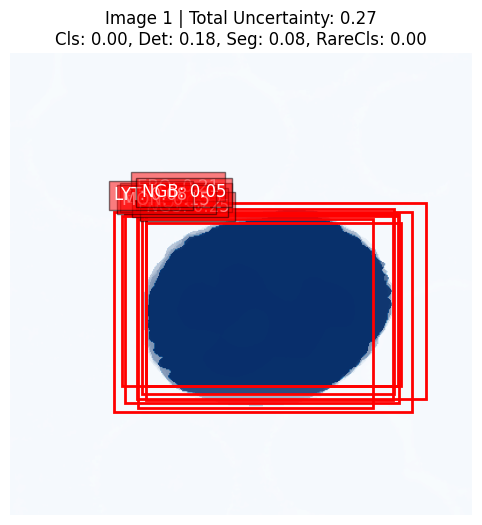

2. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_1483.jpg | Total Uncertainty: 0.29
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'MON', 'EBO', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.31
      NGS: 0.25
      EOS: 0.24
      MYO: 0.22
      MON: 0.19
      EBO: 0.15
      LYT: 0.06
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


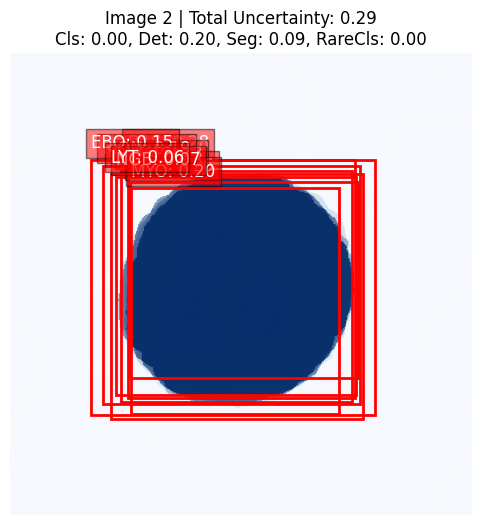

3. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_1813.jpg | Total Uncertainty: 0.29
   Predicted Classes (Sorted by Count and Score): ['NGS', 'NGB', 'BAS', 'EOS', 'MYO', 'EBO', 'MON', 'LYT']
   Class Scores:
      NGS: 0.23
      NGB: 0.06
      BAS: 0.28
      EOS: 0.22
      MYO: 0.21
      EBO: 0.18
      MON: 0.16
      LYT: 0.08
   Detected Rare Classes: ['NGB', 'BAS', 'EOS', 'EBO']


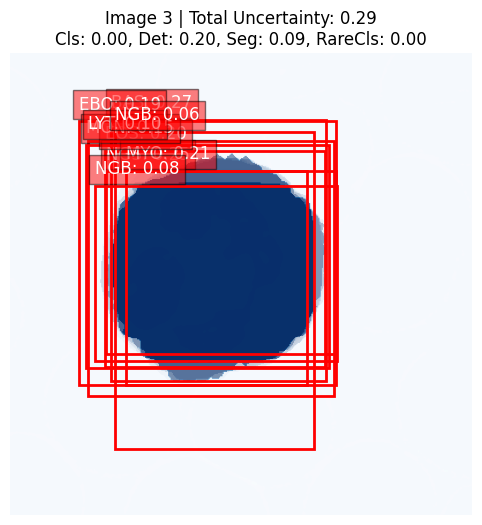

4. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/EOS_0253.jpg | Total Uncertainty: 0.29
   Predicted Classes (Sorted by Count and Score): ['BAS', 'EOS', 'NGS', 'MYO', 'MON', 'EBO', 'NGB', 'LYT']
   Class Scores:
      BAS: 0.27
      EOS: 0.26
      NGS: 0.25
      MYO: 0.22
      MON: 0.20
      EBO: 0.12
      NGB: 0.06
      LYT: 0.05
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


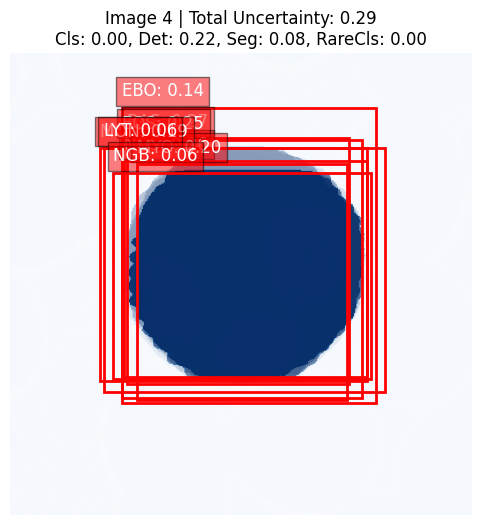

5. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_1800.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['EBO', 'BAS', 'NGS', 'EOS', 'MYO', 'MON', 'LYT', 'NGB']
   Class Scores:
      EBO: 0.15
      BAS: 0.29
      NGS: 0.24
      EOS: 0.23
      MYO: 0.21
      MON: 0.17
      LYT: 0.07
      NGB: 0.06
   Detected Rare Classes: ['EBO', 'BAS', 'EOS', 'NGB']


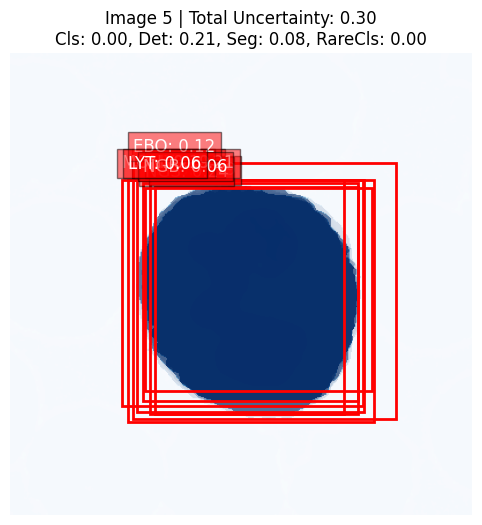

6. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_3323.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'EBO', 'MYO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.30
      NGS: 0.24
      EOS: 0.22
      EBO: 0.21
      MYO: 0.21
      MON: 0.15
      LYT: 0.09
      NGB: 0.07
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


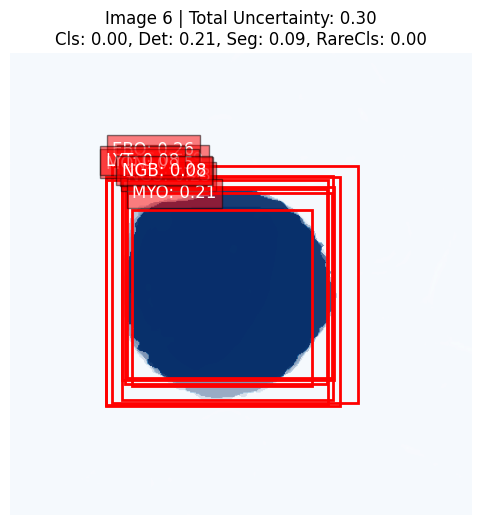

7. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_2068.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'EBO', 'MYO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.31
      NGS: 0.25
      EOS: 0.22
      EBO: 0.22
      MYO: 0.21
      MON: 0.15
      LYT: 0.08
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


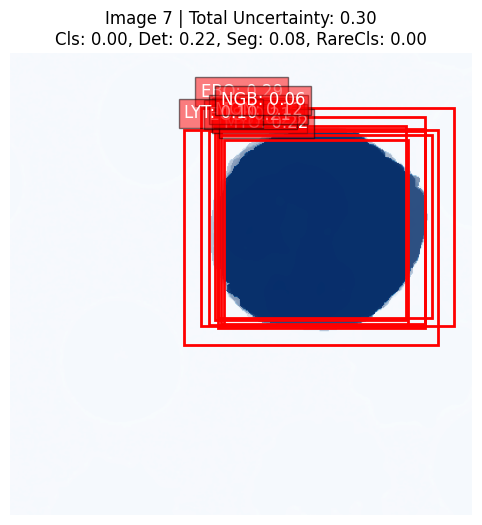

8. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_3805.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'MON', 'EBO', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.31
      NGS: 0.25
      EOS: 0.23
      MYO: 0.21
      MON: 0.17
      EBO: 0.17
      LYT: 0.07
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


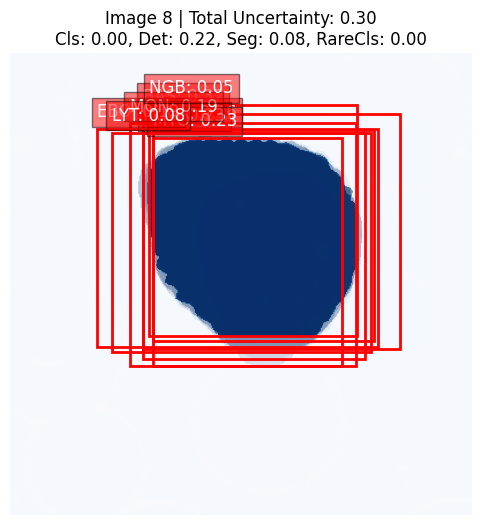

9. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_1540.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EBO', 'EOS', 'MYO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.31
      NGS: 0.24
      EBO: 0.22
      EOS: 0.22
      MYO: 0.20
      MON: 0.16
      LYT: 0.08
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EBO', 'EOS', 'NGB']


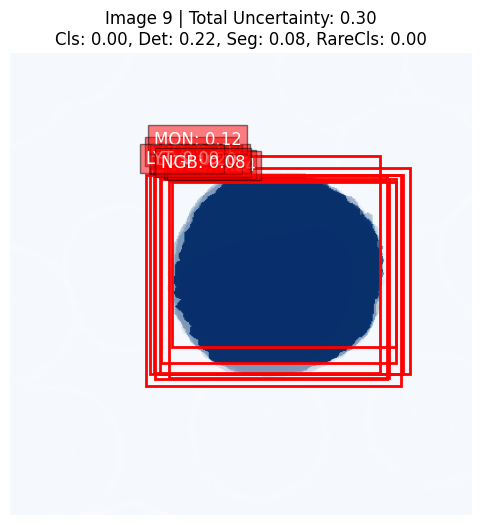

10. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_1985.jpg | Total Uncertainty: 0.31
   Predicted Classes (Sorted by Count and Score): ['MON', 'NGB', 'BAS', 'EBO', 'NGS', 'EOS', 'MYO', 'LYT']
   Class Scores:
      MON: 0.14
      NGB: 0.07
      BAS: 0.31
      EBO: 0.24
      NGS: 0.24
      EOS: 0.21
      MYO: 0.21
      LYT: 0.09
   Detected Rare Classes: ['NGB', 'BAS', 'EBO', 'EOS']


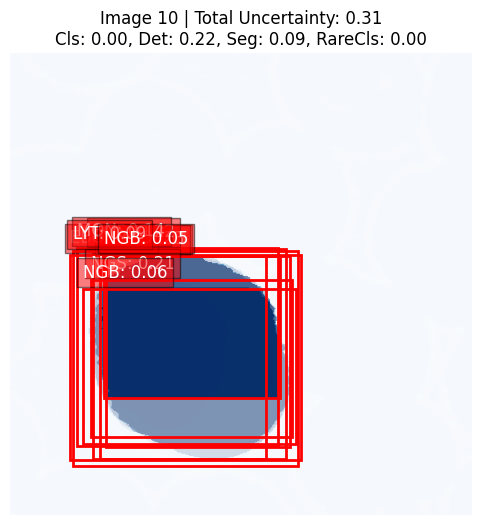

Top 10 Uncertain Images: ['NGS_2011.jpg', 'NGS_1483.jpg', 'NGS_1813.jpg', 'EOS_0253.jpg', 'NGS_1800.jpg', 'LYT_3323.jpg', 'NGS_2068.jpg', 'LYT_3805.jpg', 'LYT_1540.jpg', 'LYT_1985.jpg']


In [4]:
import random

data_root = '/kaggle/input/fudanspennsmall/SPenn/SPenn/backimages'
rare_classes = {1, 5, 7, 8}  # 稀有类别

# 获取所有图片文件
image_files = [os.path.join(data_root, f) for f in os.listdir(data_root) if f.endswith(('.jpg', '.png'))]

# 随机抽取 N 张图片
N_objects = 200  # 要检测的随机图片数量
# random.seed(42)  # 设置随机种子以确保结果可复现
random_image_files = random.sample(image_files, min(N_objects, len(image_files)))  # 随机选择图片

model1 = custom_maskrcnn_resnet50_fpn(weights=None, num_classes=9)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 使用 GPU 或 CPU
weights_path = '/kaggle/working/model_epoch_20.pth'
# weights_path = '/kaggle/input/fudanspennsmall/model_epoch_116(5).pth'
# 加载模型权重并设置为评估模式
model1.load_state_dict(torch.load(weights_path, map_location=device), strict=False)
model1.to(device)
model1.eval()

# 可视化前 10 个最不确定的图像
top_uncertain_images = []
visualize_top_uncertain_images_gpu(
    image_paths=random_image_files,  # 使用随机选择的图片列表
    model=model1,
    rare_classes=rare_classes,
    threshold=0.3,
    num_inferences=10,
    ct=0.2,
    top_n=10,
    N_objects=len(random_image_files),  # N_objects 是随机选择的图片数量
    top10uncertain=top_uncertain_images
)

# 打印结果
print("Top 10 Uncertain Images:", top_uncertain_images)





In [5]:
import os
import shutil

def move_top_uncertain_images(top_uncertain_images, source_dir, destination_dir):
    """
    根据文件名列表，将指定的图片从源路径移动到目标路径。

    Args:
        top_uncertain_images: 包含文件名的列表。
        source_dir: 源文件夹路径。
        destination_dir: 目标文件夹路径。
    """
    # 确保目标路径存在
    
    os.makedirs(destination_dir, exist_ok=True)

    for image_name in top_uncertain_images:
        source_path = os.path.join(source_dir, image_name)
        destination_path = os.path.join(destination_dir, image_name)

        if os.path.exists(source_path):
            shutil.copy(source_path, destination_path)
            print(f"Moved: {source_path} -> {destination_path}")
        else:
            print(f"File not found: {source_path}")

#image
source_path = "/kaggle/input/fudanspennsmall/SPenn/SPenn/backimages"  # 替换为实际的源路径
destination_path = "/kaggle/working/PNGImages"  # 替换为实际的目标路径
# top_uncertain_images = ["image1.png", "image2.jpg", "image3.png"]  # 替换为实际的文件名列表

move_top_uncertain_images(top_uncertain_images, source_path, destination_path)
#mask
source_path = "/kaggle/input/fudanspennsmall/SPenn/SPenn/backmasks"  # 替换为实际的源路径
destination_path = "/kaggle/working/PedMasks"  # 替换为实际的目标路径
# top_uncertain_images = ["image1.png", "image2.jpg", "image3.png"]  # 替换为实际的文件名列表

move_top_uncertain_images(top_uncertain_images, source_path, destination_path)


Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_2011.jpg -> /kaggle/working/PNGImages/NGS_2011.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_1483.jpg -> /kaggle/working/PNGImages/NGS_1483.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_1813.jpg -> /kaggle/working/PNGImages/NGS_1813.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/EOS_0253.jpg -> /kaggle/working/PNGImages/EOS_0253.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_1800.jpg -> /kaggle/working/PNGImages/NGS_1800.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_3323.jpg -> /kaggle/working/PNGImages/LYT_3323.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_2068.jpg -> /kaggle/working/PNGImages/NGS_2068.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_3805.jpg -> /kaggle/working/PNGImages/LYT_3805.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_1540.jpg -> /kag

<ipython-input-6-89255a7ebe4a>:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load(model_weights_path, map_location=device), strict=False)


Starting iteration 1/10
Epoch 1/20
Training Epoch 1: 100%|##########| 22/22 [00:11<00:00,  1.97batch/s]
Epoch: [0] lr: 0.005000  loss: 1.1753 (2.1516)  loss_classifier: 0.2985 (1.0087)  loss_box_reg: 0.1346 (0.1449)  loss_mask: 0.6595 (0.9728)  loss_objectness: 0.0115 (0.0172)  loss_rpn_box_reg: 0.0076 (0.0080)
creating index...
index created!
Averaged stats: model_time: 0.3663 (0.3757)  evaluator_time: 0.0074 (0.0073)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.064
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.200
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.064
 Average Recall     (AR) @[

Analyzing Images: 100%|██████████| 200/200 [02:27<00:00,  1.36it/s]


Top Uncertain Images:
1. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_2304.jpg | Total Uncertainty: 0.29
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.29
      NGS: 0.25
      EOS: 0.23
      MYO: 0.21
      EBO: 0.20
      MON: 0.16
      LYT: 0.08
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


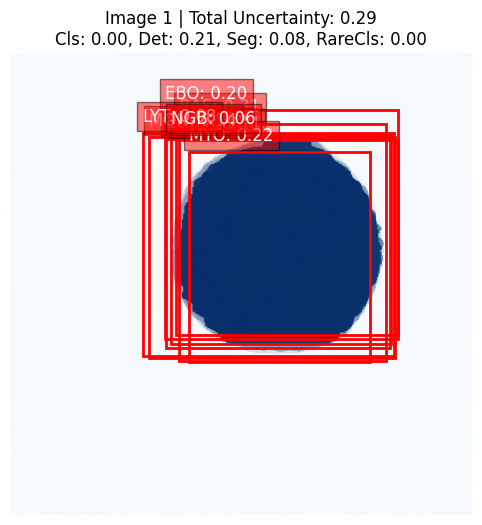

2. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/MYO_0622.jpg | Total Uncertainty: 0.29
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.30
      NGS: 0.24
      EOS: 0.24
      MYO: 0.21
      EBO: 0.19
      MON: 0.16
      LYT: 0.07
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


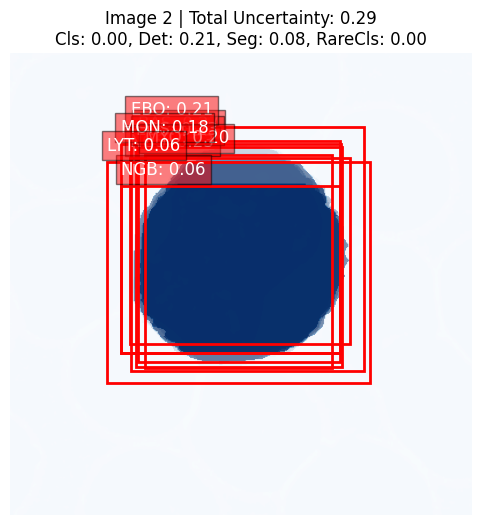

3. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/MYO_0547.jpg | Total Uncertainty: 0.29
   Predicted Classes (Sorted by Count and Score): ['NGS', 'NGB', 'BAS', 'EOS', 'MYO', 'EBO', 'MON', 'LYT']
   Class Scores:
      NGS: 0.23
      NGB: 0.06
      BAS: 0.31
      EOS: 0.23
      MYO: 0.22
      EBO: 0.22
      MON: 0.15
      LYT: 0.09
   Detected Rare Classes: ['NGB', 'BAS', 'EOS', 'EBO']


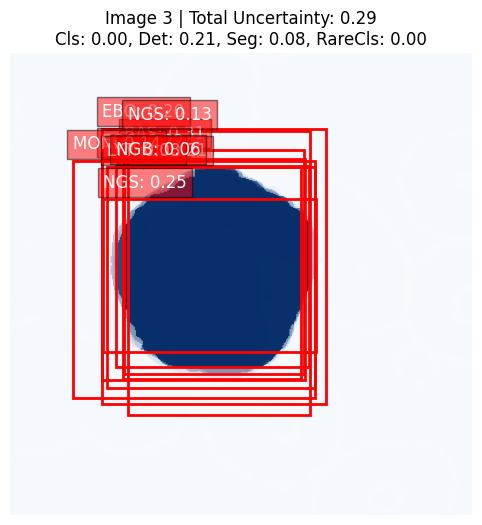

4. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_1223.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['MYO', 'EOS', 'BAS', 'EBO', 'NGS', 'MON', 'LYT', 'NGB']
   Class Scores:
      MYO: 0.18
      EOS: 0.19
      BAS: 0.30
      EBO: 0.26
      NGS: 0.23
      MON: 0.12
      LYT: 0.10
      NGB: 0.07
   Detected Rare Classes: ['EOS', 'BAS', 'EBO', 'NGB']


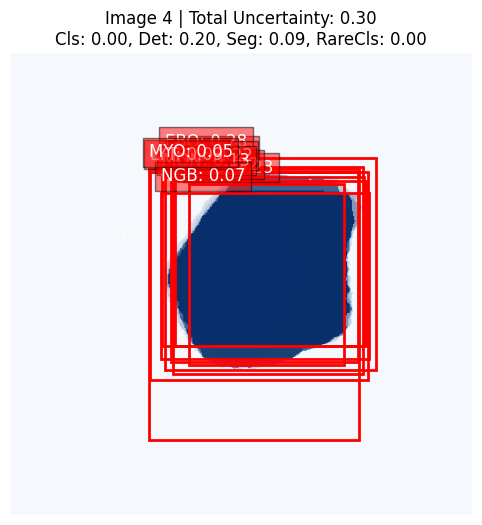

5. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/EOS_0181.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EBO', 'EOS', 'MYO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.29
      NGS: 0.23
      EBO: 0.22
      EOS: 0.22
      MYO: 0.20
      MON: 0.14
      LYT: 0.10
      NGB: 0.07
   Detected Rare Classes: ['BAS', 'EBO', 'EOS', 'NGB']


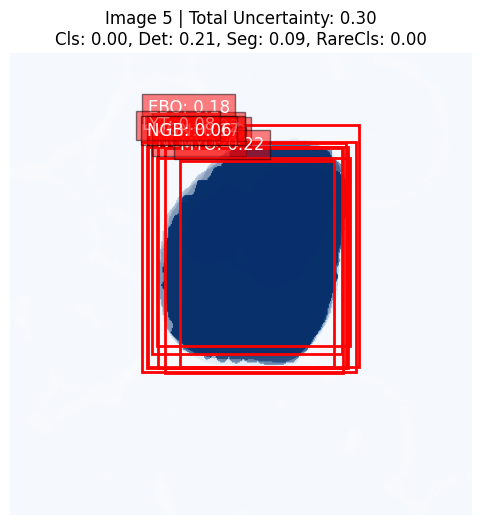

6. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_3612.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['BAS', 'EBO', 'NGS', 'MYO', 'EOS', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.32
      EBO: 0.25
      NGS: 0.23
      MYO: 0.23
      EOS: 0.21
      MON: 0.13
      LYT: 0.10
      NGB: 0.07
   Detected Rare Classes: ['BAS', 'EBO', 'EOS', 'NGB']


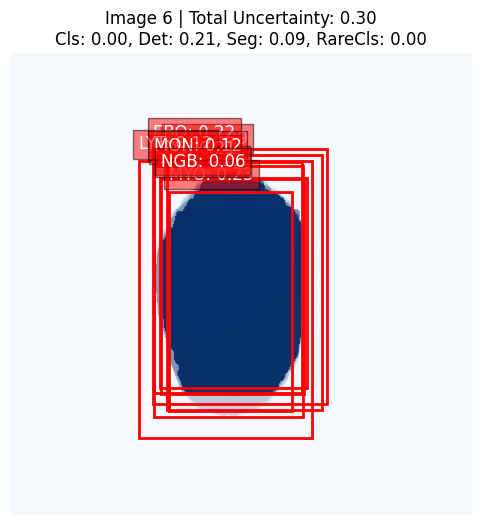

7. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_0132.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'MON', 'EBO', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.29
      NGS: 0.24
      EOS: 0.23
      MYO: 0.21
      MON: 0.18
      EBO: 0.18
      LYT: 0.07
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


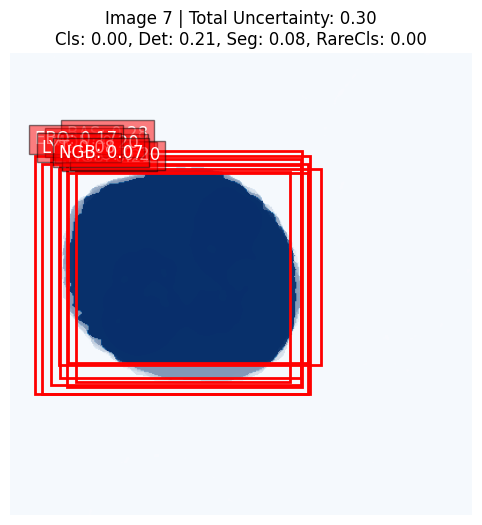

8. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_1113.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['MYO', 'BAS', 'NGS', 'EOS', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      MYO: 0.17
      BAS: 0.27
      NGS: 0.24
      EOS: 0.22
      EBO: 0.20
      MON: 0.17
      LYT: 0.08
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


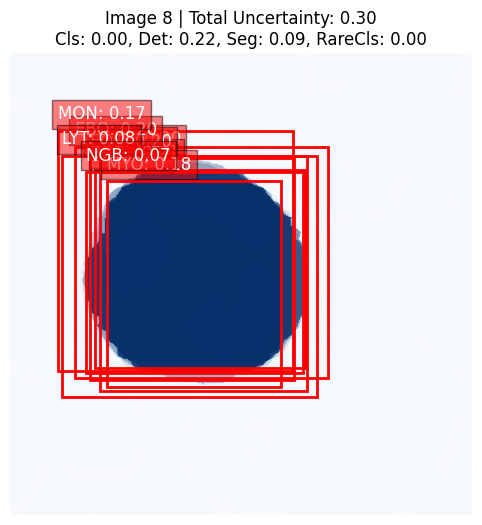

9. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_1314.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['EBO', 'BAS', 'MYO', 'NGS', 'EOS', 'LYT', 'MON', 'NGB']
   Class Scores:
      EBO: 0.36
      BAS: 0.31
      MYO: 0.20
      NGS: 0.19
      EOS: 0.18
      LYT: 0.12
      MON: 0.10
      NGB: 0.07
   Detected Rare Classes: ['EBO', 'BAS', 'EOS', 'NGB']


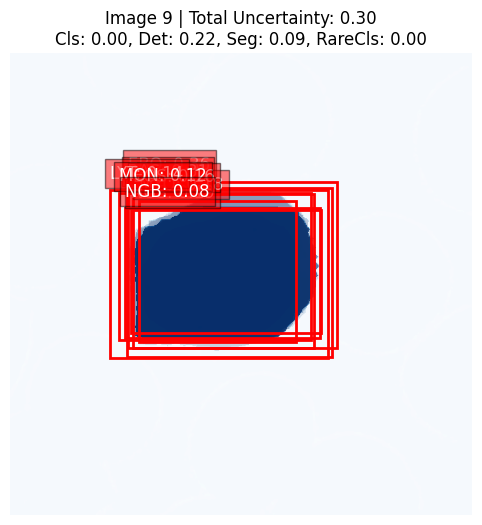

10. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_0591.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.31
      NGS: 0.24
      EOS: 0.23
      MYO: 0.21
      EBO: 0.21
      MON: 0.15
      LYT: 0.09
      NGB: 0.07
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


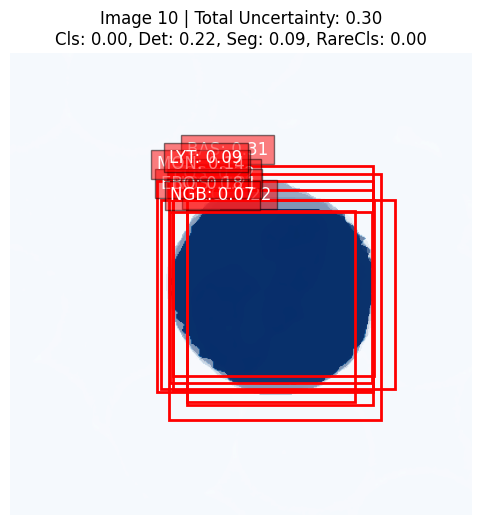

Iteration 1: Top 10 Uncertain Images: ['NGS_2304.jpg', 'MYO_0622.jpg', 'MYO_0547.jpg', 'LYT_1223.jpg', 'EOS_0181.jpg', 'LYT_3612.jpg', 'NGS_0132.jpg', 'NGS_1113.jpg', 'LYT_1314.jpg', 'NGS_0591.jpg']
Iteration 1: Dataset content saved to /kaggle/working/iteration_1
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_2304.jpg -> /kaggle/working/PNGImages/NGS_2304.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/MYO_0622.jpg -> /kaggle/working/PNGImages/MYO_0622.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/MYO_0547.jpg -> /kaggle/working/PNGImages/MYO_0547.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_1223.jpg -> /kaggle/working/PNGImages/LYT_1223.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/EOS_0181.jpg -> /kaggle/working/PNGImages/EOS_0181.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_3612.jpg -> /kaggle/working/PNGImages/LYT_3612.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SP

Analyzing Images: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]


Top Uncertain Images:
1. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_1015.jpg | Total Uncertainty: 0.28
   Predicted Classes (Sorted by Count and Score): ['MYO', 'BAS', 'NGS', 'EOS', 'MON', 'EBO', 'LYT', 'NGB']
   Class Scores:
      MYO: 0.20
      BAS: 0.29
      NGS: 0.25
      EOS: 0.24
      MON: 0.17
      EBO: 0.16
      LYT: 0.07
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


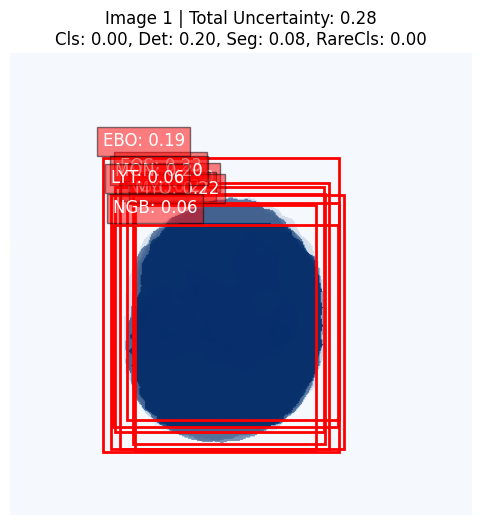

2. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_1813.jpg | Total Uncertainty: 0.29
   Predicted Classes (Sorted by Count and Score): ['NGB', 'BAS', 'NGS', 'EOS', 'MYO', 'EBO', 'MON', 'LYT']
   Class Scores:
      NGB: 0.06
      BAS: 0.28
      NGS: 0.24
      EOS: 0.22
      MYO: 0.21
      EBO: 0.17
      MON: 0.16
      LYT: 0.07
   Detected Rare Classes: ['NGB', 'BAS', 'EOS', 'EBO']


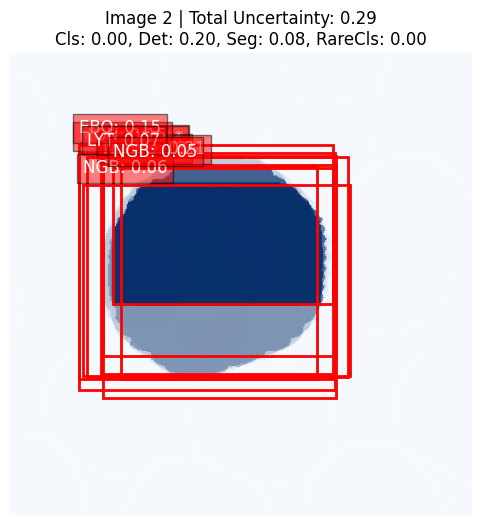

3. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/MON_0580.jpg | Total Uncertainty: 0.29
   Predicted Classes (Sorted by Count and Score): ['EBO', 'MYO', 'BAS', 'NGS', 'EOS', 'MON', 'LYT', 'NGB']
   Class Scores:
      EBO: 0.19
      MYO: 0.19
      BAS: 0.30
      NGS: 0.23
      EOS: 0.23
      MON: 0.16
      LYT: 0.08
      NGB: 0.06
   Detected Rare Classes: ['EBO', 'BAS', 'EOS', 'NGB']


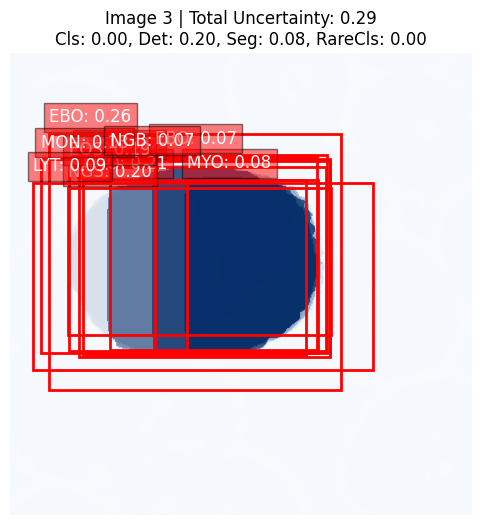

4. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_1056.jpg | Total Uncertainty: 0.29
   Predicted Classes (Sorted by Count and Score): ['MYO', 'BAS', 'NGS', 'EOS', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      MYO: 0.20
      BAS: 0.28
      NGS: 0.22
      EOS: 0.22
      EBO: 0.19
      MON: 0.17
      LYT: 0.08
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


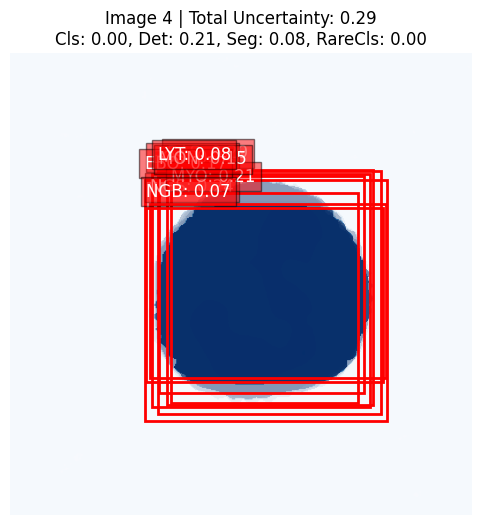

5. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_0277.jpg | Total Uncertainty: 0.29
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.30
      NGS: 0.23
      EOS: 0.22
      MYO: 0.20
      EBO: 0.19
      MON: 0.18
      LYT: 0.08
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


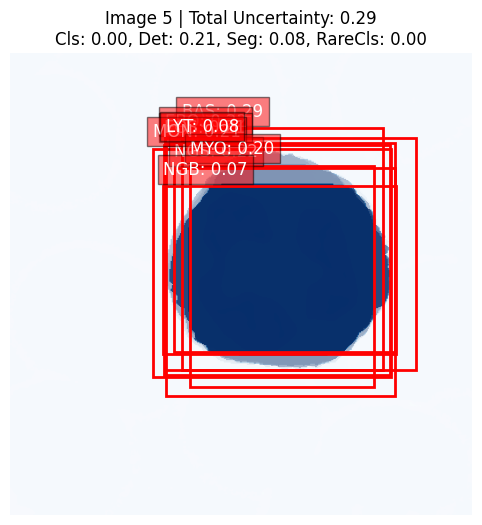

6. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_1825.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.31
      NGS: 0.24
      EOS: 0.24
      MYO: 0.22
      EBO: 0.20
      MON: 0.17
      LYT: 0.08
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


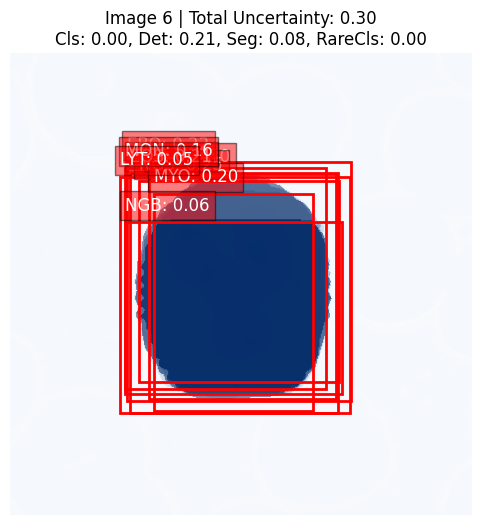

7. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_3805.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['MON', 'BAS', 'EOS', 'NGS', 'MYO', 'EBO', 'LYT', 'NGB']
   Class Scores:
      MON: 0.17
      BAS: 0.30
      EOS: 0.24
      NGS: 0.23
      MYO: 0.21
      EBO: 0.19
      LYT: 0.08
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


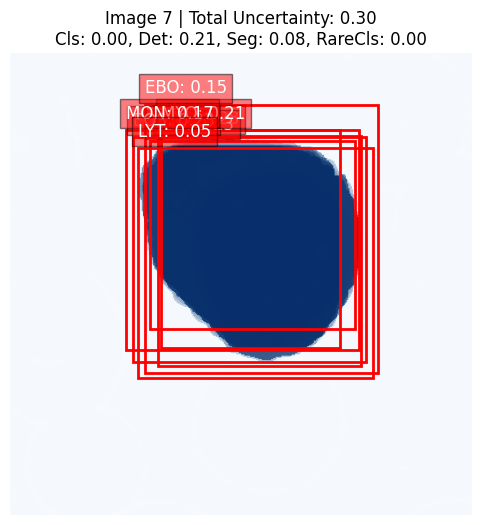

8. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/MYO_1338.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.32
      NGS: 0.25
      EOS: 0.23
      MYO: 0.21
      EBO: 0.19
      MON: 0.16
      LYT: 0.08
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


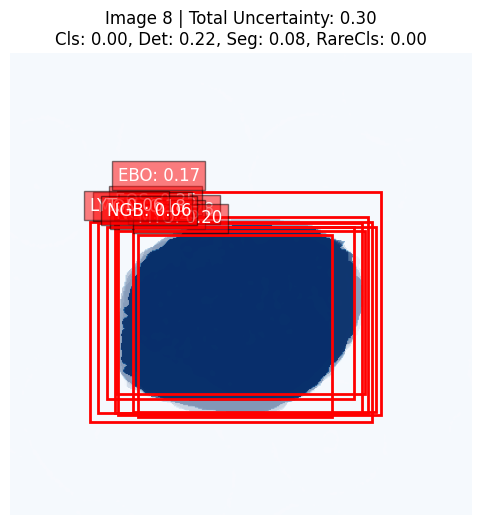

9. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_1692.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.32
      NGS: 0.23
      EOS: 0.23
      MYO: 0.21
      EBO: 0.21
      MON: 0.15
      LYT: 0.09
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


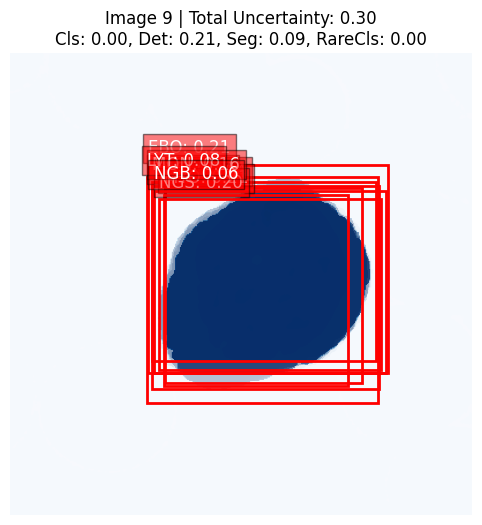

10. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_2051.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['BAS', 'EBO', 'NGS', 'EOS', 'MYO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.32
      EBO: 0.24
      NGS: 0.24
      EOS: 0.22
      MYO: 0.21
      MON: 0.14
      LYT: 0.09
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EBO', 'EOS', 'NGB']


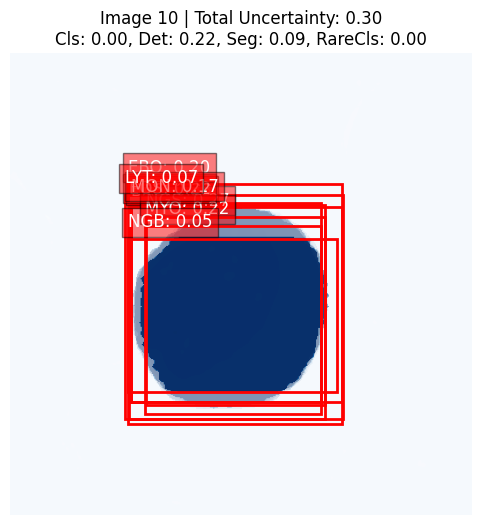

Iteration 2: Top 10 Uncertain Images: ['NGS_1015.jpg', 'NGS_1813.jpg', 'MON_0580.jpg', 'NGS_1056.jpg', 'NGS_0277.jpg', 'NGS_1825.jpg', 'LYT_3805.jpg', 'MYO_1338.jpg', 'LYT_1692.jpg', 'LYT_2051.jpg']
Iteration 2: Dataset content saved to /kaggle/working/iteration_2
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_1015.jpg -> /kaggle/working/PNGImages/NGS_1015.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_1813.jpg -> /kaggle/working/PNGImages/NGS_1813.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/MON_0580.jpg -> /kaggle/working/PNGImages/MON_0580.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_1056.jpg -> /kaggle/working/PNGImages/NGS_1056.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_0277.jpg -> /kaggle/working/PNGImages/NGS_0277.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_1825.jpg -> /kaggle/working/PNGImages/NGS_1825.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SP

Analyzing Images: 100%|██████████| 200/200 [02:27<00:00,  1.36it/s]


Top Uncertain Images:
1. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/MYO_1326.jpg | Total Uncertainty: 0.26
   Predicted Classes (Sorted by Count and Score): ['MYO', 'BAS', 'EOS', 'NGS', 'MON', 'EBO', 'LYT', 'NGB']
   Class Scores:
      MYO: 0.21
      BAS: 0.29
      EOS: 0.27
      NGS: 0.25
      MON: 0.18
      EBO: 0.14
      LYT: 0.06
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


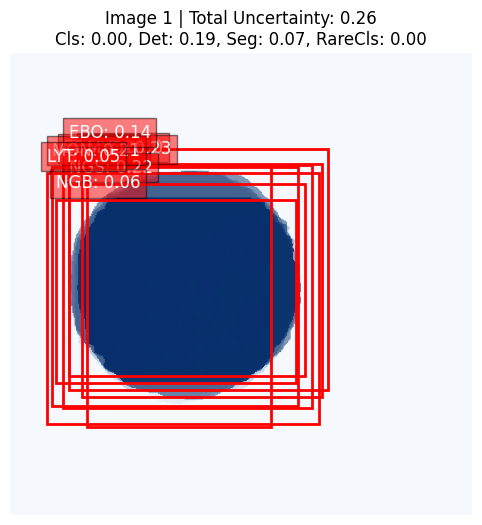

2. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_0429.jpg | Total Uncertainty: 0.28
   Predicted Classes (Sorted by Count and Score): ['MON', 'BAS', 'NGS', 'EOS', 'MYO', 'EBO', 'NGB', 'LYT']
   Class Scores:
      MON: 0.17
      BAS: 0.29
      NGS: 0.27
      EOS: 0.23
      MYO: 0.22
      EBO: 0.15
      NGB: 0.06
      LYT: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


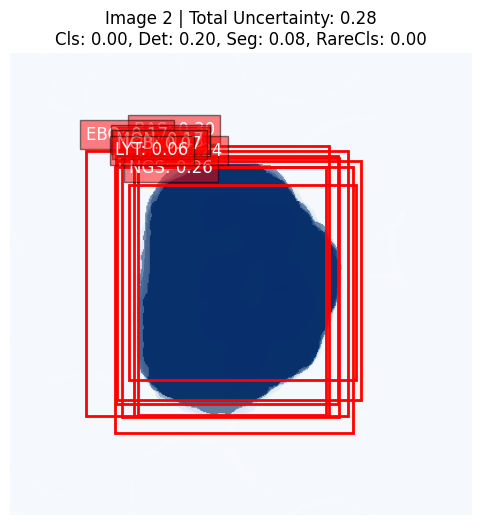

3. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_2704.jpg | Total Uncertainty: 0.28
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.31
      NGS: 0.24
      EOS: 0.23
      MYO: 0.21
      EBO: 0.19
      MON: 0.16
      LYT: 0.07
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


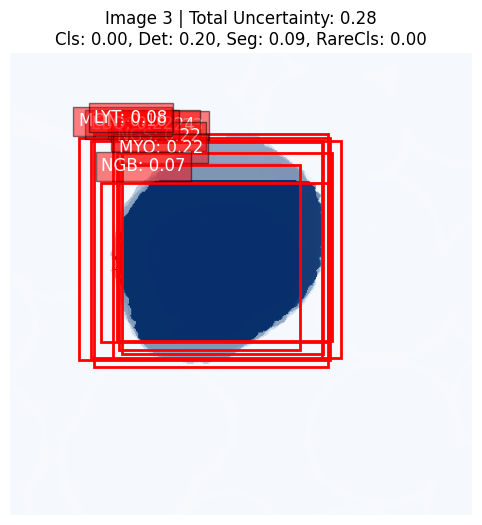

4. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_0195.jpg | Total Uncertainty: 0.29
   Predicted Classes (Sorted by Count and Score): ['MYO', 'BAS', 'NGS', 'EOS', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      MYO: 0.21
      BAS: 0.29
      NGS: 0.24
      EOS: 0.23
      EBO: 0.19
      MON: 0.17
      LYT: 0.07
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


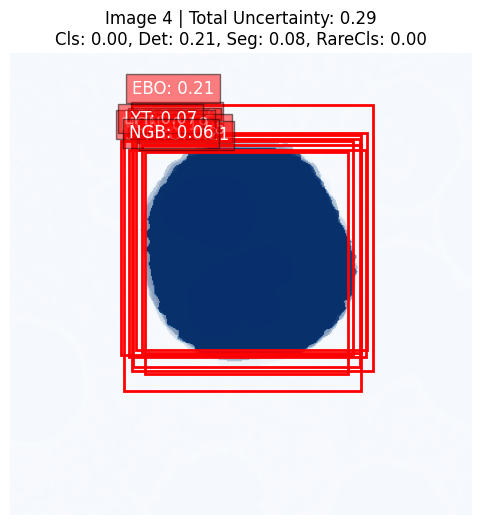

5. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_0760.jpg | Total Uncertainty: 0.29
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.30
      NGS: 0.26
      EOS: 0.23
      MYO: 0.22
      EBO: 0.21
      MON: 0.16
      LYT: 0.08
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


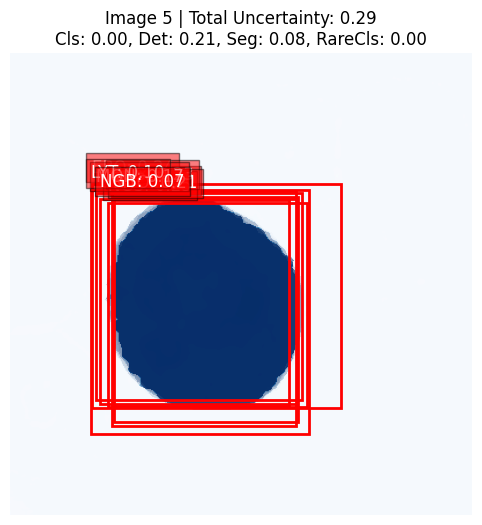

6. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_2154.jpg | Total Uncertainty: 0.29
   Predicted Classes (Sorted by Count and Score): ['MYO', 'EBO', 'BAS', 'NGS', 'EOS', 'LYT', 'MON', 'NGB']
   Class Scores:
      MYO: 0.16
      EBO: 0.42
      BAS: 0.29
      NGS: 0.18
      EOS: 0.16
      LYT: 0.13
      MON: 0.10
      NGB: 0.07
   Detected Rare Classes: ['EBO', 'BAS', 'EOS', 'NGB']


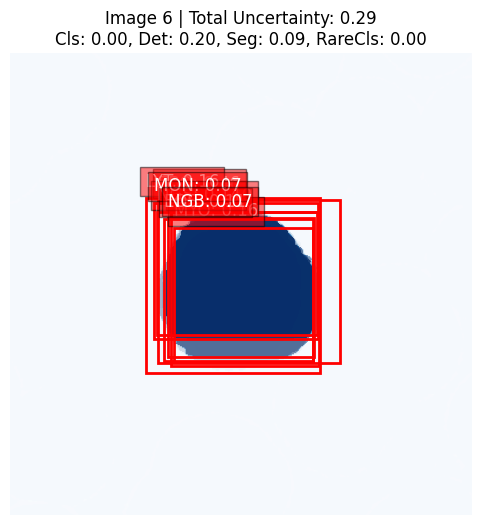

7. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/EOS_0401.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['MYO', 'BAS', 'EOS', 'NGS', 'MON', 'EBO', 'NGB', 'LYT']
   Class Scores:
      MYO: 0.21
      BAS: 0.29
      EOS: 0.26
      NGS: 0.24
      MON: 0.18
      EBO: 0.13
      NGB: 0.06
      LYT: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


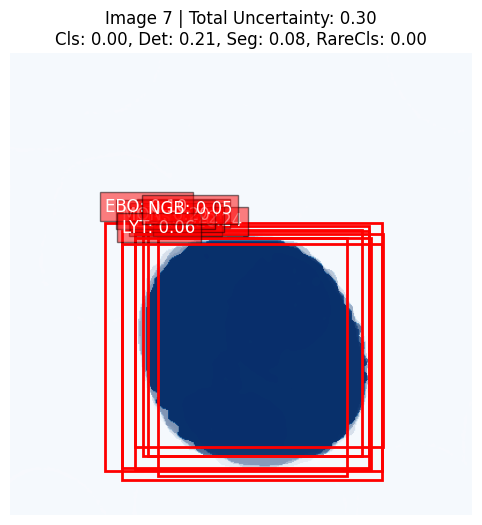

8. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_1088.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['BAS', 'EOS', 'NGS', 'MYO', 'MON', 'EBO', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.29
      EOS: 0.24
      NGS: 0.23
      MYO: 0.22
      MON: 0.17
      EBO: 0.16
      LYT: 0.07
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


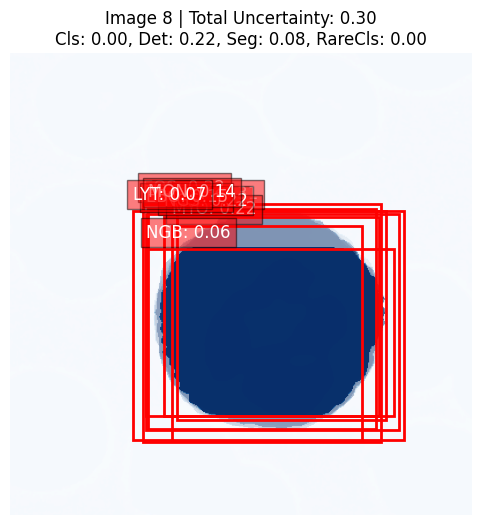

9. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/BAS_0067.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['BAS', 'EOS', 'NGS', 'MYO', 'MON', 'EBO', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.29
      EOS: 0.26
      NGS: 0.24
      MYO: 0.22
      MON: 0.18
      EBO: 0.12
      LYT: 0.06
      NGB: 0.05
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


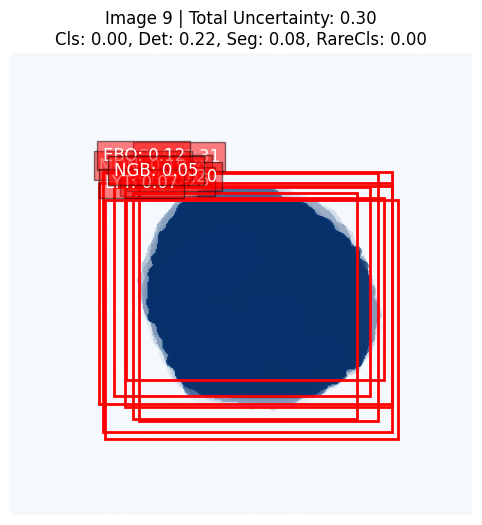

10. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_0881.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'MON', 'EBO', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.28
      NGS: 0.25
      EOS: 0.24
      MYO: 0.21
      MON: 0.18
      EBO: 0.14
      LYT: 0.07
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


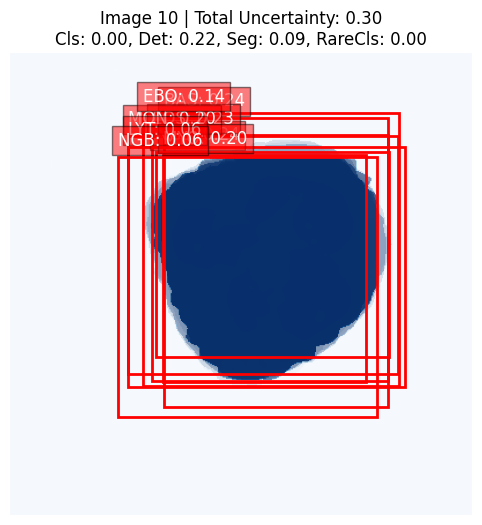

Iteration 3: Top 10 Uncertain Images: ['MYO_1326.jpg', 'NGS_0429.jpg', 'LYT_2704.jpg', 'NGS_0195.jpg', 'NGS_0760.jpg', 'LYT_2154.jpg', 'EOS_0401.jpg', 'NGS_1088.jpg', 'BAS_0067.jpg', 'NGS_0881.jpg']
Iteration 3: Dataset content saved to /kaggle/working/iteration_3
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/MYO_1326.jpg -> /kaggle/working/PNGImages/MYO_1326.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_0429.jpg -> /kaggle/working/PNGImages/NGS_0429.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_2704.jpg -> /kaggle/working/PNGImages/LYT_2704.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_0195.jpg -> /kaggle/working/PNGImages/NGS_0195.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_0760.jpg -> /kaggle/working/PNGImages/NGS_0760.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_2154.jpg -> /kaggle/working/PNGImages/LYT_2154.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SP

Analyzing Images: 100%|██████████| 200/200 [02:27<00:00,  1.36it/s]


Top Uncertain Images:
1. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_2823.jpg | Total Uncertainty: 0.29
   Predicted Classes (Sorted by Count and Score): ['NGS', 'MYO', 'BAS', 'EBO', 'EOS', 'MON', 'LYT', 'NGB']
   Class Scores:
      NGS: 0.22
      MYO: 0.19
      BAS: 0.31
      EBO: 0.27
      EOS: 0.21
      MON: 0.14
      LYT: 0.10
      NGB: 0.07
   Detected Rare Classes: ['BAS', 'EBO', 'EOS', 'NGB']


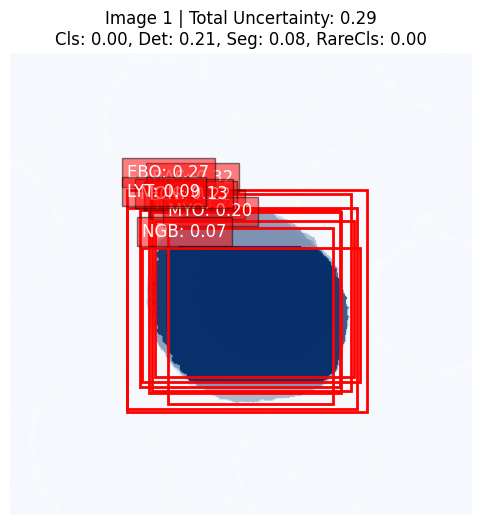

2. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_1453.jpg | Total Uncertainty: 0.29
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.30
      NGS: 0.25
      EOS: 0.23
      MYO: 0.21
      EBO: 0.19
      MON: 0.17
      LYT: 0.07
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


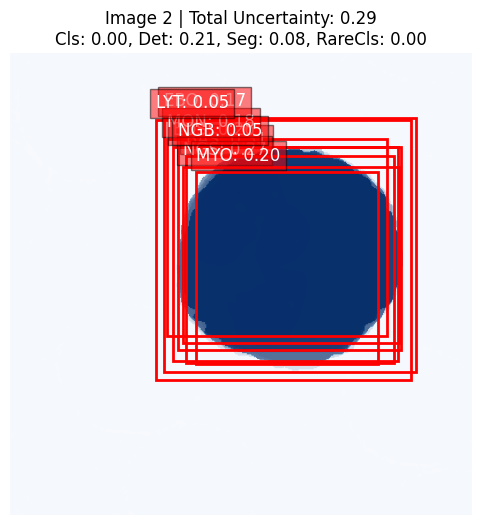

3. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_1177.jpg | Total Uncertainty: 0.29
   Predicted Classes (Sorted by Count and Score): ['MYO', 'BAS', 'NGS', 'EOS', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      MYO: 0.18
      BAS: 0.29
      NGS: 0.24
      EOS: 0.22
      EBO: 0.19
      MON: 0.16
      LYT: 0.08
      NGB: 0.07
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


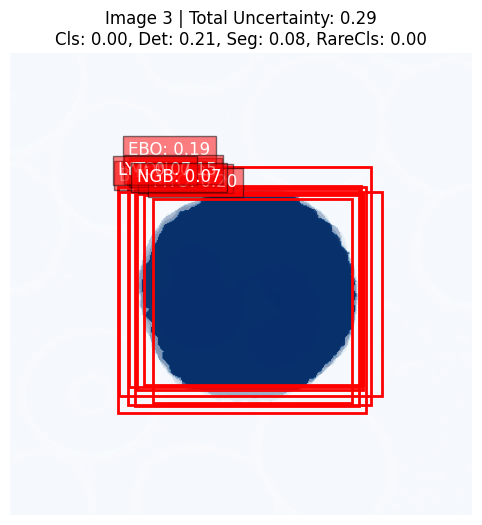

4. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_0679.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'MON', 'EBO', 'NGB', 'LYT']
   Class Scores:
      BAS: 0.29
      NGS: 0.25
      EOS: 0.25
      MYO: 0.21
      MON: 0.18
      EBO: 0.15
      NGB: 0.06
      LYT: 0.07
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


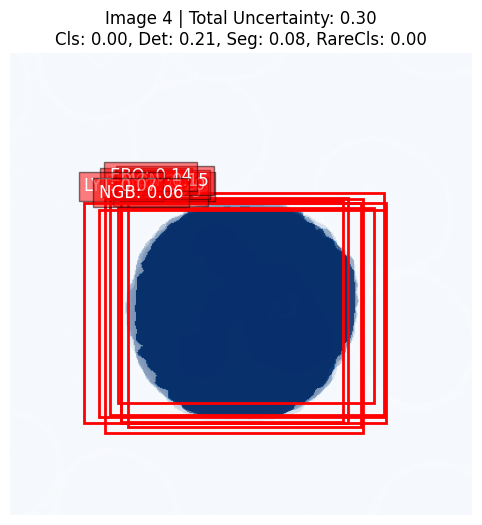

5. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_2092.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.32
      NGS: 0.25
      EOS: 0.23
      MYO: 0.21
      EBO: 0.20
      MON: 0.16
      LYT: 0.08
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


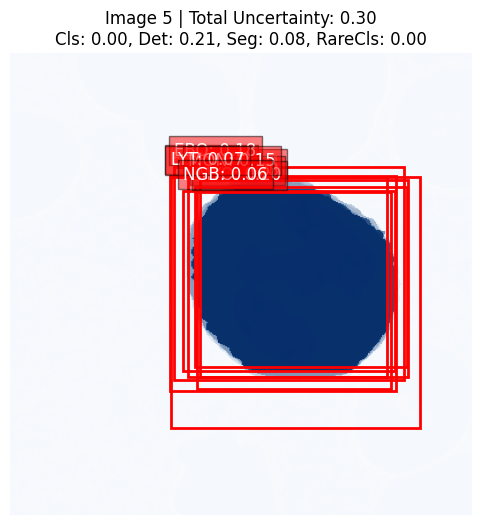

6. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_1618.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['BAS', 'EOS', 'NGS', 'MYO', 'MON', 'EBO', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.28
      EOS: 0.24
      NGS: 0.23
      MYO: 0.22
      MON: 0.18
      EBO: 0.17
      LYT: 0.07
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


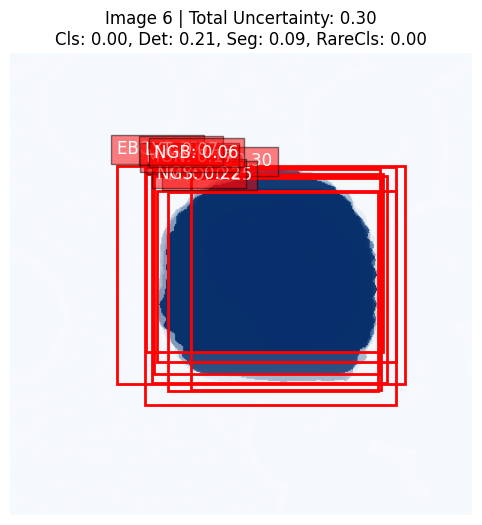

7. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_1288.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['BAS', 'EOS', 'NGS', 'MYO', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.31
      EOS: 0.25
      NGS: 0.25
      MYO: 0.21
      EBO: 0.20
      MON: 0.16
      LYT: 0.08
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


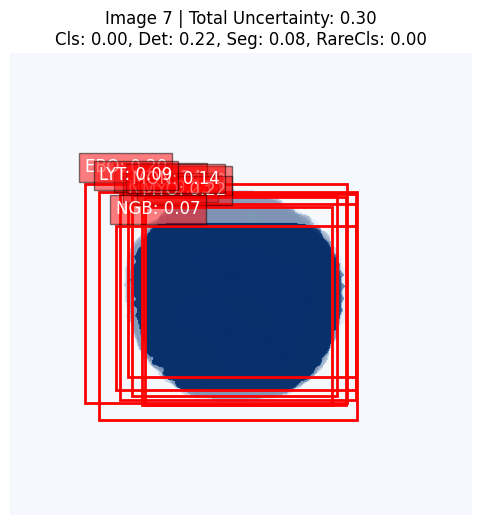

8. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_2704.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['MYO', 'BAS', 'NGS', 'EOS', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      MYO: 0.19
      BAS: 0.31
      NGS: 0.24
      EOS: 0.22
      EBO: 0.21
      MON: 0.15
      LYT: 0.08
      NGB: 0.07
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


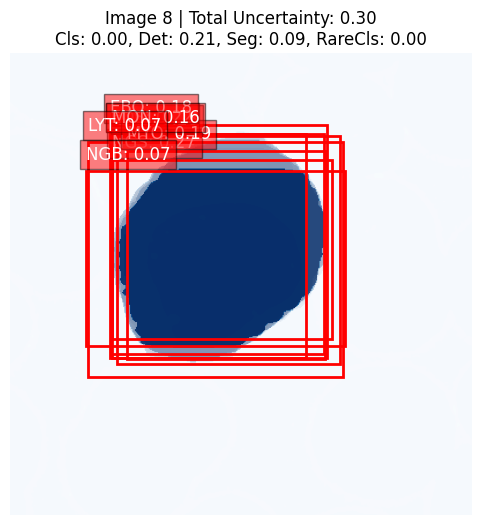

9. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/MON_1574.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'MON', 'EBO', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.28
      NGS: 0.25
      EOS: 0.25
      MYO: 0.21
      MON: 0.18
      EBO: 0.13
      LYT: 0.06
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


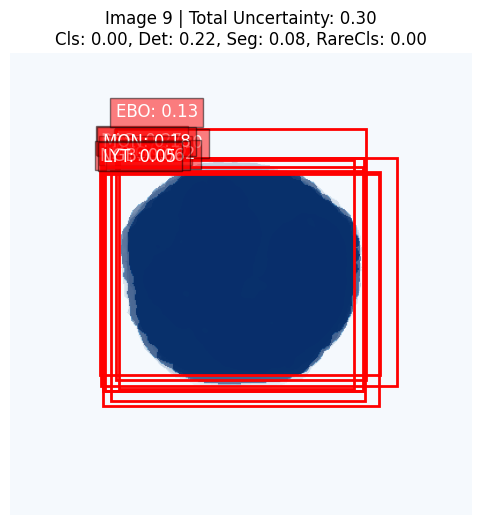

10. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_0160.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['NGS', 'MYO', 'BAS', 'EOS', 'MON', 'EBO', 'NGB', 'LYT']
   Class Scores:
      NGS: 0.22
      MYO: 0.21
      BAS: 0.29
      EOS: 0.25
      MON: 0.19
      EBO: 0.15
      NGB: 0.06
      LYT: 0.07
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


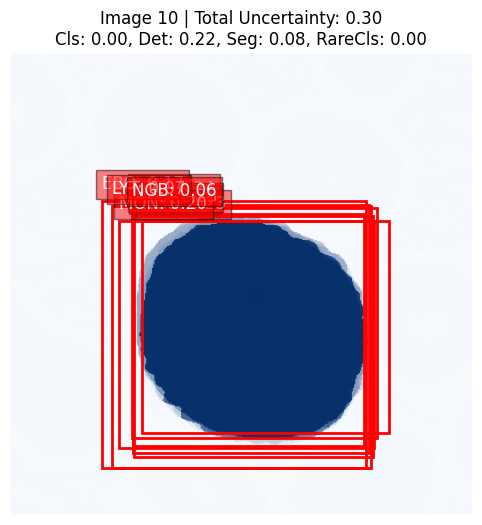

Iteration 4: Top 10 Uncertain Images: ['LYT_2823.jpg', 'NGS_1453.jpg', 'NGS_1177.jpg', 'NGS_0679.jpg', 'NGS_2092.jpg', 'LYT_1618.jpg', 'NGS_1288.jpg', 'LYT_2704.jpg', 'MON_1574.jpg', 'NGS_0160.jpg']
Iteration 4: Dataset content saved to /kaggle/working/iteration_4
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_2823.jpg -> /kaggle/working/PNGImages/LYT_2823.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_1453.jpg -> /kaggle/working/PNGImages/NGS_1453.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_1177.jpg -> /kaggle/working/PNGImages/NGS_1177.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_0679.jpg -> /kaggle/working/PNGImages/NGS_0679.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_2092.jpg -> /kaggle/working/PNGImages/NGS_2092.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_1618.jpg -> /kaggle/working/PNGImages/LYT_1618.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SP

Analyzing Images: 100%|██████████| 200/200 [02:27<00:00,  1.35it/s]


Top Uncertain Images:
1. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_0386.jpg | Total Uncertainty: 0.29
   Predicted Classes (Sorted by Count and Score): ['MYO', 'BAS', 'NGS', 'EOS', 'MON', 'EBO', 'NGB', 'LYT']
   Class Scores:
      MYO: 0.19
      BAS: 0.27
      NGS: 0.25
      EOS: 0.23
      MON: 0.20
      EBO: 0.12
      NGB: 0.06
      LYT: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


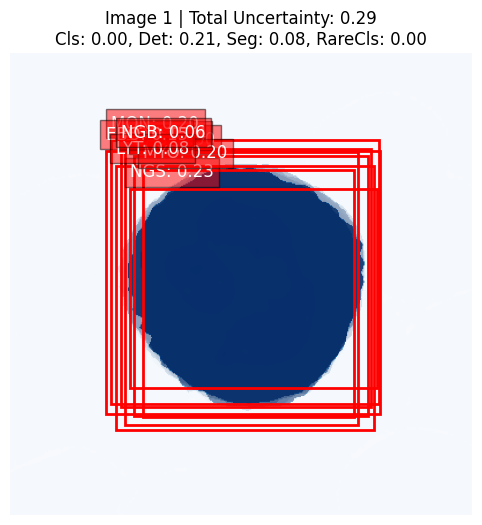

2. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_1320.jpg | Total Uncertainty: 0.29
   Predicted Classes (Sorted by Count and Score): ['BAS', 'EBO', 'NGS', 'EOS', 'MYO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.31
      EBO: 0.26
      NGS: 0.24
      EOS: 0.23
      MYO: 0.20
      MON: 0.14
      LYT: 0.10
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EBO', 'EOS', 'NGB']


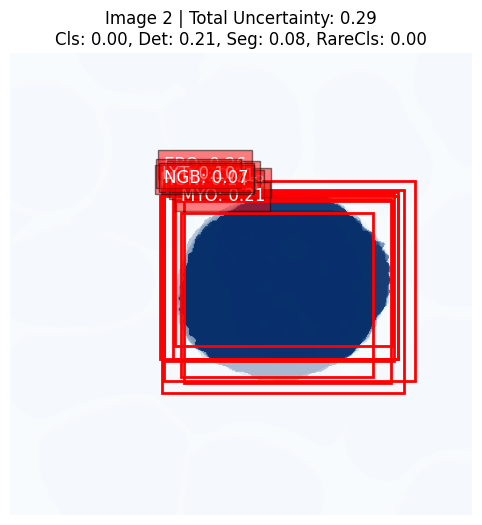

3. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_0651.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['MYO', 'BAS', 'EBO', 'NGS', 'EOS', 'MON', 'LYT', 'NGB']
   Class Scores:
      MYO: 0.20
      BAS: 0.32
      EBO: 0.25
      NGS: 0.25
      EOS: 0.24
      MON: 0.15
      LYT: 0.09
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EBO', 'EOS', 'NGB']


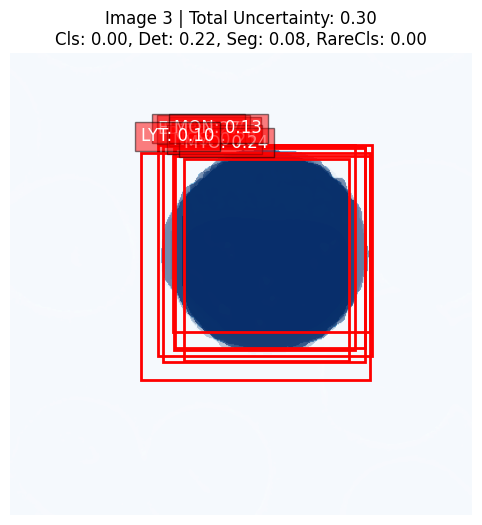

4. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_2304.jpg | Total Uncertainty: 0.31
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.29
      NGS: 0.25
      EOS: 0.24
      MYO: 0.21
      EBO: 0.19
      MON: 0.16
      LYT: 0.08
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


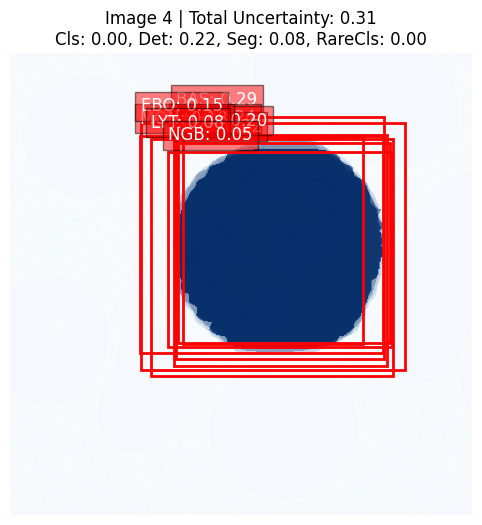

5. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_2426.jpg | Total Uncertainty: 0.31
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.29
      NGS: 0.24
      EOS: 0.23
      MYO: 0.21
      EBO: 0.18
      MON: 0.15
      LYT: 0.07
      NGB: 0.07
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


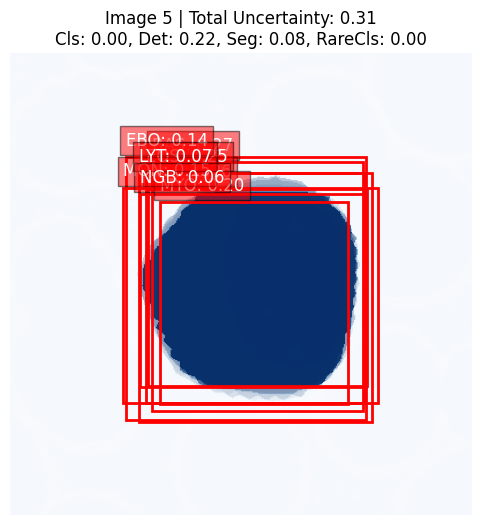

6. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/MYO_0547.jpg | Total Uncertainty: 0.31
   Predicted Classes (Sorted by Count and Score): ['NGB', 'BAS', 'NGS', 'EOS', 'MYO', 'EBO', 'MON', 'LYT']
   Class Scores:
      NGB: 0.06
      BAS: 0.31
      NGS: 0.24
      EOS: 0.24
      MYO: 0.22
      EBO: 0.21
      MON: 0.16
      LYT: 0.09
   Detected Rare Classes: ['NGB', 'BAS', 'EOS', 'EBO']


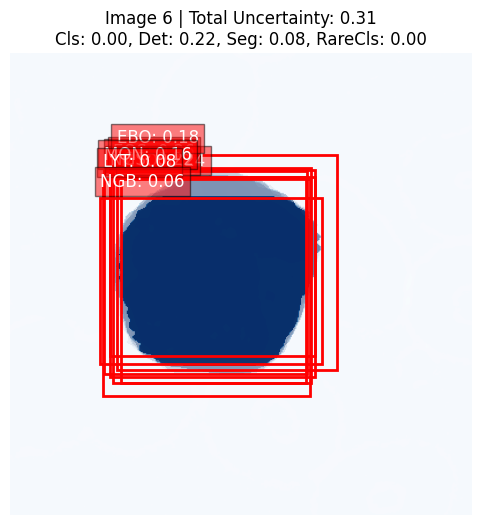

7. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_1235.jpg | Total Uncertainty: 0.31
   Predicted Classes (Sorted by Count and Score): ['EBO', 'BAS', 'MYO', 'LYT', 'NGS', 'EOS', 'NGB', 'MON']
   Class Scores:
      EBO: 0.41
      BAS: 0.25
      MYO: 0.15
      LYT: 0.15
      NGS: 0.14
      EOS: 0.13
      NGB: 0.09
      MON: 0.08
   Detected Rare Classes: ['EBO', 'BAS', 'EOS', 'NGB']


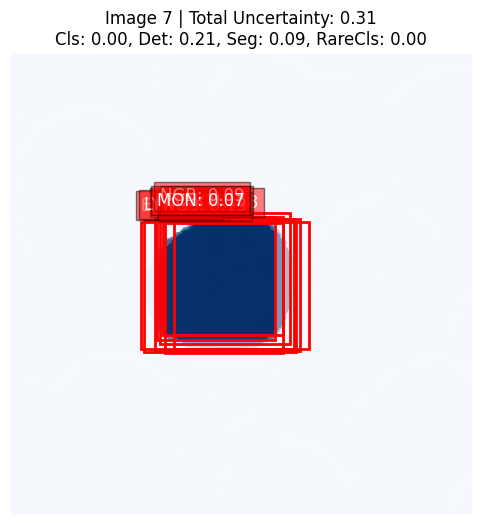

8. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_0132.jpg | Total Uncertainty: 0.31
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'MON', 'EBO', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.24
      NGS: 0.24
      EOS: 0.23
      MYO: 0.20
      MON: 0.19
      EBO: 0.16
      LYT: 0.07
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


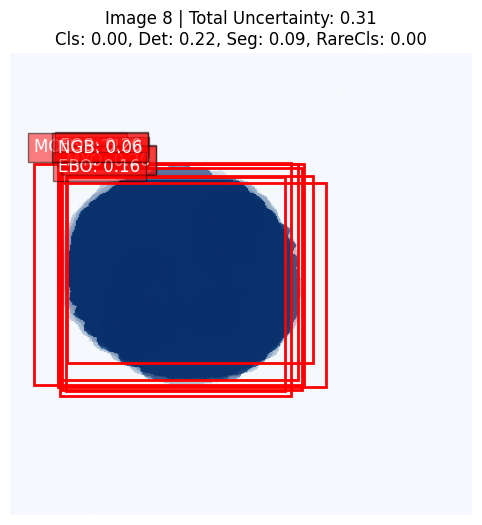

9. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_0459.jpg | Total Uncertainty: 0.31
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'MON', 'EBO', 'NGB', 'LYT']
   Class Scores:
      BAS: 0.28
      NGS: 0.25
      EOS: 0.24
      MYO: 0.22
      MON: 0.19
      EBO: 0.15
      NGB: 0.06
      LYT: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


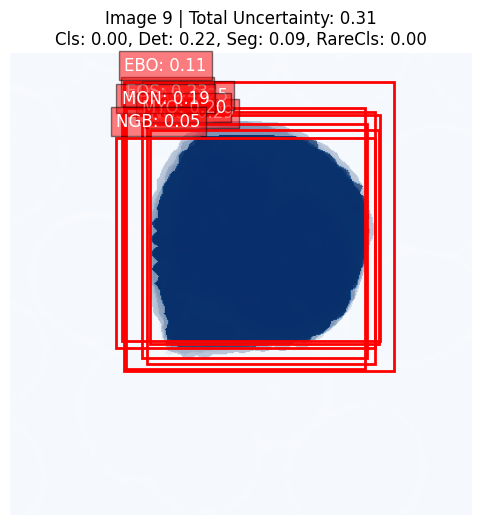

10. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_2652.jpg | Total Uncertainty: 0.31
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.27
      NGS: 0.25
      EOS: 0.23
      MYO: 0.20
      EBO: 0.18
      MON: 0.17
      LYT: 0.08
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


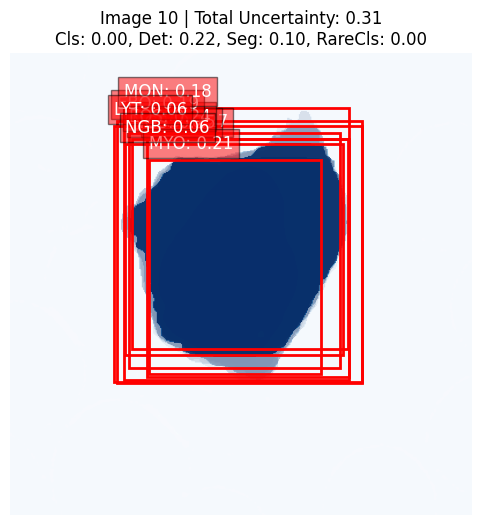

Iteration 5: Top 10 Uncertain Images: ['NGS_0386.jpg', 'LYT_1320.jpg', 'LYT_0651.jpg', 'NGS_2304.jpg', 'LYT_2426.jpg', 'MYO_0547.jpg', 'LYT_1235.jpg', 'NGS_0132.jpg', 'NGS_0459.jpg', 'LYT_2652.jpg']
Iteration 5: Dataset content saved to /kaggle/working/iteration_5
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_0386.jpg -> /kaggle/working/PNGImages/NGS_0386.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_1320.jpg -> /kaggle/working/PNGImages/LYT_1320.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_0651.jpg -> /kaggle/working/PNGImages/LYT_0651.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_2304.jpg -> /kaggle/working/PNGImages/NGS_2304.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_2426.jpg -> /kaggle/working/PNGImages/LYT_2426.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/MYO_0547.jpg -> /kaggle/working/PNGImages/MYO_0547.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SP

Analyzing Images: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


Top Uncertain Images:
1. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/MYO_1199.jpg | Total Uncertainty: 0.28
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'EBO', 'MYO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.30
      NGS: 0.22
      EOS: 0.21
      EBO: 0.24
      MYO: 0.22
      MON: 0.15
      LYT: 0.09
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


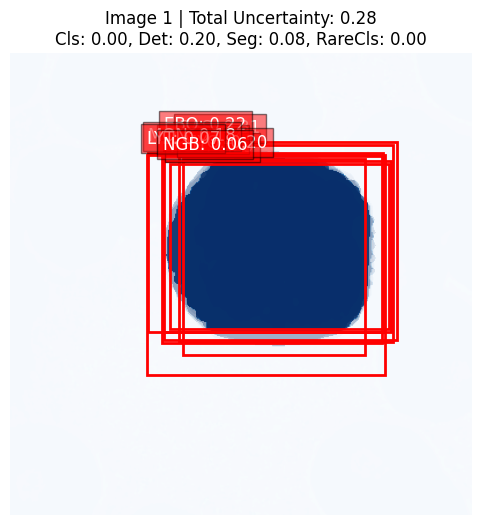

2. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_1288.jpg | Total Uncertainty: 0.29
   Predicted Classes (Sorted by Count and Score): ['BAS', 'EOS', 'NGS', 'MYO', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.28
      EOS: 0.24
      NGS: 0.23
      MYO: 0.21
      EBO: 0.19
      MON: 0.16
      LYT: 0.08
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


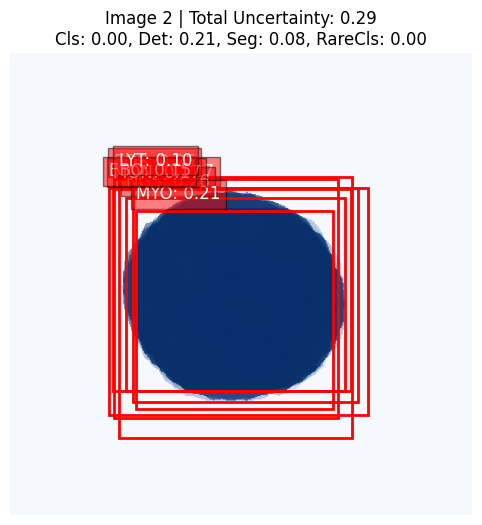

3. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/EOS_0307.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.30
      NGS: 0.25
      EOS: 0.24
      MYO: 0.22
      EBO: 0.17
      MON: 0.17
      LYT: 0.08
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


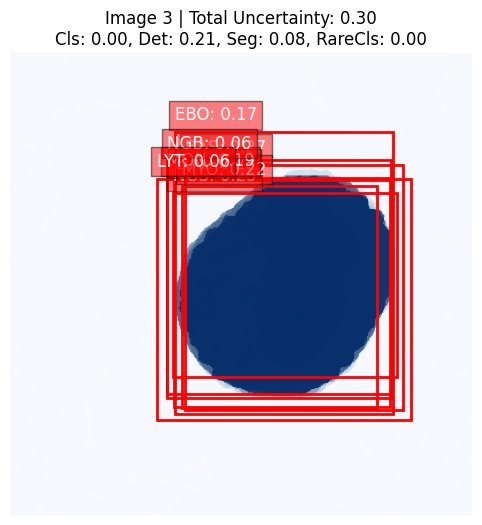

4. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_3612.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['MYO', 'MON', 'BAS', 'EBO', 'NGS', 'EOS', 'LYT', 'NGB']
   Class Scores:
      MYO: 0.20
      MON: 0.11
      BAS: 0.32
      EBO: 0.26
      NGS: 0.23
      EOS: 0.20
      LYT: 0.11
      NGB: 0.07
   Detected Rare Classes: ['BAS', 'EBO', 'EOS', 'NGB']


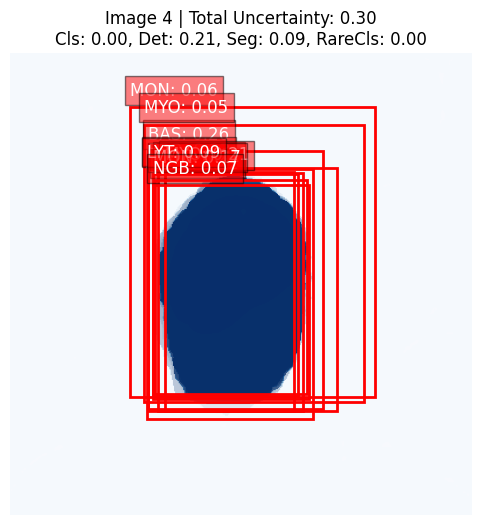

5. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_0364.jpg | Total Uncertainty: 0.30
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'EBO', 'MYO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.27
      NGS: 0.23
      EOS: 0.23
      EBO: 0.21
      MYO: 0.20
      MON: 0.16
      LYT: 0.08
      NGB: 0.07
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


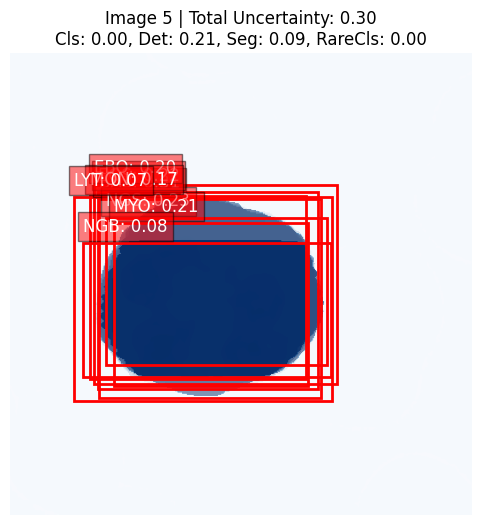

6. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_0277.jpg | Total Uncertainty: 0.31
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.28
      NGS: 0.24
      EOS: 0.23
      MYO: 0.21
      EBO: 0.20
      MON: 0.17
      LYT: 0.07
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


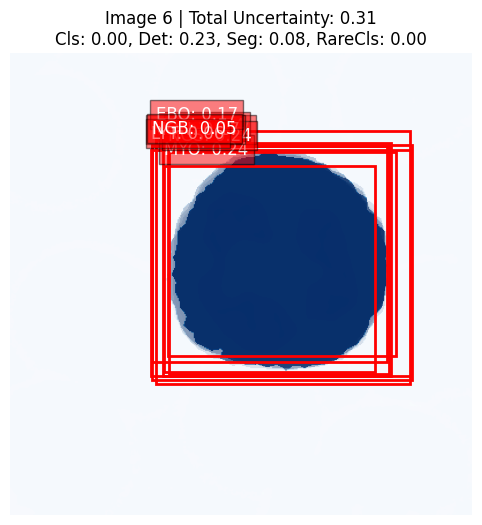

7. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_0760.jpg | Total Uncertainty: 0.31
   Predicted Classes (Sorted by Count and Score): ['MYO', 'BAS', 'NGS', 'EOS', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      MYO: 0.21
      BAS: 0.31
      NGS: 0.24
      EOS: 0.22
      EBO: 0.20
      MON: 0.16
      LYT: 0.08
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


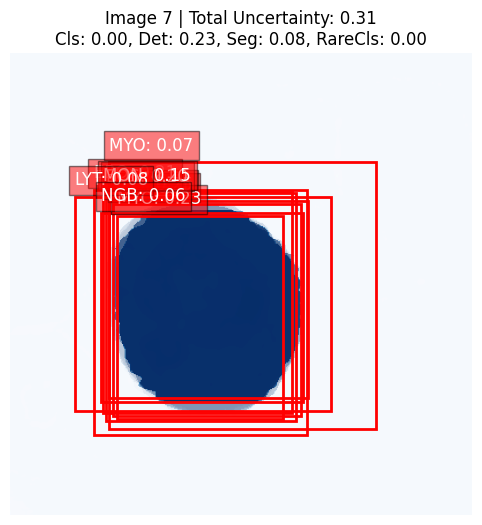

8. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_0704.jpg | Total Uncertainty: 0.31
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EBO', 'EOS', 'MYO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.33
      NGS: 0.24
      EBO: 0.23
      EOS: 0.20
      MYO: 0.20
      MON: 0.14
      LYT: 0.09
      NGB: 0.07
   Detected Rare Classes: ['BAS', 'EBO', 'EOS', 'NGB']


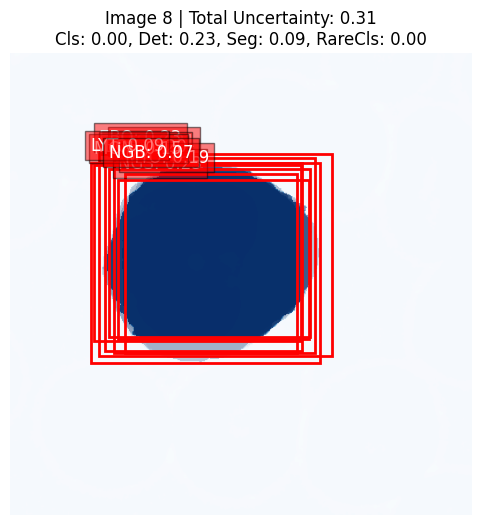

9. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_2235.jpg | Total Uncertainty: 0.31
   Predicted Classes (Sorted by Count and Score): ['MYO', 'BAS', 'NGS', 'EBO', 'EOS', 'MON', 'LYT', 'NGB']
   Class Scores:
      MYO: 0.20
      BAS: 0.29
      NGS: 0.24
      EBO: 0.23
      EOS: 0.22
      MON: 0.15
      LYT: 0.10
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EBO', 'EOS', 'NGB']


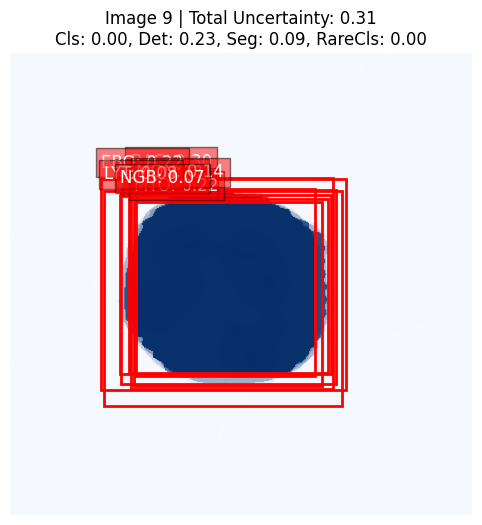

10. File: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_1453.jpg | Total Uncertainty: 0.32
   Predicted Classes (Sorted by Count and Score): ['BAS', 'NGS', 'EOS', 'MYO', 'EBO', 'MON', 'LYT', 'NGB']
   Class Scores:
      BAS: 0.28
      NGS: 0.24
      EOS: 0.22
      MYO: 0.21
      EBO: 0.18
      MON: 0.16
      LYT: 0.07
      NGB: 0.06
   Detected Rare Classes: ['BAS', 'EOS', 'EBO', 'NGB']


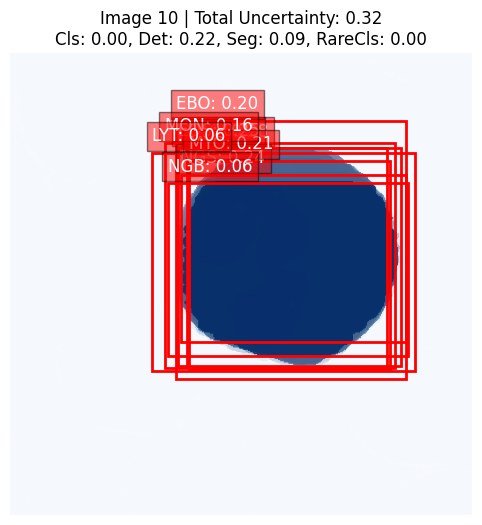

Iteration 6: Top 10 Uncertain Images: ['MYO_1199.jpg', 'NGS_1288.jpg', 'EOS_0307.jpg', 'LYT_3612.jpg', 'NGS_0364.jpg', 'NGS_0277.jpg', 'NGS_0760.jpg', 'LYT_0704.jpg', 'NGS_2235.jpg', 'NGS_1453.jpg']
Iteration 6: Dataset content saved to /kaggle/working/iteration_6
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/MYO_1199.jpg -> /kaggle/working/PNGImages/MYO_1199.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_1288.jpg -> /kaggle/working/PNGImages/NGS_1288.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/EOS_0307.jpg -> /kaggle/working/PNGImages/EOS_0307.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/LYT_3612.jpg -> /kaggle/working/PNGImages/LYT_3612.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_0364.jpg -> /kaggle/working/PNGImages/NGS_0364.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SPenn/backimages/NGS_0277.jpg -> /kaggle/working/PNGImages/NGS_0277.jpg
Moved: /kaggle/input/fudanspennsmall/SPenn/SP

KeyboardInterrupt: 

In [6]:
# start from 2nd iteration
# 使用输出重定向功能

def main():
    # 判断当前机器的GPU是否可用
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # 背景 + 目标类别
    num_classes = 9

    # dataset = PennFudanDataset('/kaggle/input/fudanspennsmall/SPenn/SPenn', get_transform(train=True))
    # dataset_test = PennFudanDataset('/kaggle/input/fudanspennsmall/SPenn/SPenn', get_transform(train=False))

    dataset = PennFudanDataset('/kaggle/working', get_transform(train=True))
    dataset_test = PennFudanDataset('/kaggle/working', get_transform(train=False))

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=utils.collate_fn
    )
    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=4, shuffle=False, num_workers=4, collate_fn=utils.collate_fn
    )

    model = get_model_instance_segmentation(num_classes)
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    # optimizer = torch.optim.Adam(params, lr=0.005, weight_decay=0.0005)

    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    num_epochs = 20 #40
    from tqdm import tqdm

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        # tqdm 监视 data_loader 的进度
        data_loader_with_progress = tqdm(data_loader, desc=f"Training Epoch {epoch + 1}", unit="batch")
    
        # 使用 train_one_epoch 进行训练
        train_one_epoch(model, optimizer, data_loader_with_progress, device, epoch, print_freq=len(data_loader))
        
        # 更新学习率调度器
        lr_scheduler.step()
    
        # 评估模型
        evaluate(model, data_loader_test, device=device)
    
        # 保存模型权重
        output_dir = "/kaggle/working/"
        torch.save(model.state_dict(), os.path.join(output_dir, f"model_epoch_{epoch+1}.pth"))
    
    print("Training complete. Model weights are saved.")
def main_with_logging():
    log_path = "/kaggle/working/training_logs.json"  # 保存日志的路径
    logger = MultiOutputLogger(log_path)

    # 为每次运行创建唯一的运行标识符
    run_id = f"run_{len(logger.load_existing_logs()) + 1}"

    # 使用上下文管理器捕获输出，同时打印到终端
    with redirect_stdout(logger), redirect_stderr(logger):
        main()  # 调用您的主函数，所有输出将被捕获并记录

    # 保存日志到文件
    logger.save_to_file(run_id)
    print(f"Training logs saved to: {log_path}")



if __name__ == "__main__":
    # 设置迭代次数
    N = 7  # 5 迭代次数

    # 设置参数
    data_root = '/kaggle/input/fudanspennsmall/SPenn/SPenn/backimages'
    rare_classes = {1, 5, 7, 8}  # 稀有类别
    model_weights_path = '/kaggle/working/model_epoch_20.pth'  # 模型权重路径
    images_source_path = '/kaggle/input/fudanspennsmall/SPenn/SPenn/backimages'  # 原始图片路径
    masks_source_path = '/kaggle/input/fudanspennsmall/SPenn/SPenn/backmasks'  # 原始掩码路径
    images_dest_path = '/kaggle/working/PNGImages'  # 目标图片路径
    masks_dest_path = '/kaggle/working/PedMasks'  # 目标掩码路径
    newadd_data_path = 'kaggle/working'
    # 初始化模型
    model1 = custom_maskrcnn_resnet50_fpn(weights=None, num_classes=9)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model1.load_state_dict(torch.load(model_weights_path, map_location=device), strict=False)
    model1.to(device)
    model1.eval()

    for iteration in range(N):
        
        
        print(f"Starting iteration {iteration + 1}/{N}")

        #training
        main_with_logging()
        
        # 随机选择图片
        image_files = [os.path.join(data_root, f) for f in os.listdir(data_root) if f.endswith(('.jpg', '.png'))]
        N_objects = 200  # 每次处理的图片数量
        random_image_files = random.sample(image_files, min(N_objects, len(image_files)))

        # 不确定性分析
        top_uncertain_images = []
        visualize_top_uncertain_images_gpu(
            image_paths=random_image_files,
            model=model1,
            rare_classes=rare_classes,
            threshold=0.3,
            num_inferences=10,
            ct=0.2,
            top_n=10,
            N_objects=len(random_image_files),
            top10uncertain=top_uncertain_images
        )

        # 打印结果
        # 打印结果
        print(f"Iteration {iteration + 1}: Top 10 Uncertain Images:", top_uncertain_images)

        # 单独保存一份每次迭代的图片
        import shutil

        # 保存每次迭代更新前的数据集内容
        iteration_folder = f'/kaggle/working/iteration_{iteration+1}'  # 创建新的迭代文件夹
        os.makedirs(iteration_folder, exist_ok=True)

        # 拷贝PNGImages文件夹中的数据到迭代文件夹下
        shutil.copytree(images_dest_path, os.path.join(iteration_folder),dirs_exist_ok=True)
        # shutil.copytree(masks_dest_path, os.path.join(iteration_folder, 'PedMasks'))

        print(f"Iteration {iteration + 1}: Dataset content saved to {iteration_folder}")

            
        # 将前 10 张不确定图片复制到训练数据中
        # move_top_uncertain_images(top_uncertain_images, source_path, destination_path)
        
        move_top_uncertain_images(top_uncertain_images, images_source_path, images_dest_path)  # 复制图片
        move_top_uncertain_images(top_uncertain_images, masks_source_path, masks_dest_path)  # 复制掩码


        print(f"Iteration {iteration + 1} complete.")


In [7]:
import os
import shutil
import zipfile
from tqdm import tqdm

def zip_selected_directories(base_path, target_dirs, output_filename):
    """
    将指定目录下的选定文件夹压缩成zip文件，并显示进度条
    
    参数:
    base_path -- 基础目录路径
    target_dirs -- 要压缩的子目录列表
    output_filename -- 输出的zip文件名（包含路径）
    """
    # 确保基础目录存在
    if not os.path.exists(base_path):
        print(f"错误: 基础目录 {base_path} 不存在")
        return False
    
    # 验证目标子目录存在
    valid_dirs = []
    for dir_name in target_dirs:
        dir_path = os.path.join(base_path, dir_name)
        if os.path.exists(dir_path):
            valid_dirs.append(dir_name)
        else:
            print(f"警告: 目录 {dir_path} 不存在，将被跳过")
    
    if not valid_dirs:
        print("错误: 没有有效的目录可以压缩")
        return False
    
    try:
        # 统计文件总数，用于进度条
        total_files = 0
        for dir_name in valid_dirs:
            dir_path = os.path.join(base_path, dir_name)
            for root, dirs, files in os.walk(dir_path):
                total_files += len(files)
        
        print(f"开始压缩 {len(valid_dirs)} 个目录中的 {total_files} 个文件...")
        
        # 创建zip文件
        with zipfile.ZipFile(output_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
            # 使用tqdm创建进度条
            with tqdm(total=total_files, unit="files") as pbar:
                # 遍历每个有效目录
                for dir_name in valid_dirs:
                    dir_path = os.path.join(base_path, dir_name)
                    # 遍历目录中的所有文件和子目录
                    for root, dirs, files in os.walk(dir_path):
                        for file in files:
                            # 构建文件的完整路径
                            file_path = os.path.join(root, file)
                            # 计算在zip文件中的相对路径（保持目录结构）
                            rel_path = os.path.relpath(file_path, base_path)
                            # 将文件添加到zip
                            zipf.write(file_path, rel_path)
                            # 更新进度条
                            pbar.update(1)
        
        print(f"压缩完成: {output_filename}")
        print(f"压缩文件大小: {os.path.getsize(output_filename) / (1024*1024):.2f} MB")
        return True
    except Exception as e:
        print(f"压缩过程中出错: {e}")
        return False

# 定义基础目录和要压缩的子目录
base_directory = "/kaggle/working"
target_directories = [
    "iteration_1",
    "iteration_2",
    "iteration_3",
    "iteration_4",
    "iteration_5",
    "iteration_6",
    "iteration_7",
    "iteration_8"
]

# 输出zip文件路径
output_zip = "/kaggle/working/active-learning-4-cell.zip"

# 执行压缩
zip_selected_directories(base_directory, target_directories, output_zip)

警告: 目录 /kaggle/working/iteration_7 不存在，将被跳过
警告: 目录 /kaggle/working/iteration_8 不存在，将被跳过
开始压缩 6 个目录中的 647 个文件...


100%|██████████| 647/647 [00:00<00:00, 2106.43files/s]

压缩完成: /kaggle/working/active-learning-4-cell.zip
压缩文件大小: 9.22 MB


True